# Identifying Spam Mails
we were recently hired in start up company and you were asked to build a system to identify spam emails

In [52]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score
#from sklearn.utils import s1804
from collections import Counter

from sklearn.metrics import roc_curve, auc
from sklearn import metrics

from nltk.corpus import stopwords

from nltk.sentiment.vader import SentimentIntensityAnalyzer

from nltk.stem import WordNetLemmatizer

from nltk.tokenize import word_tokenize
import gensim
from gensim.utils import simple_preprocess

from gensim.parsing.preprocessing import STOPWORDS

from nltk.stem import WordNetLemmatizer, SnowballStemmer
#from nltk.stem import *
import numpy as np
np.random.seed(400)
import nltk
#nltk.download('vader_lexicon')
import warnings
warnings.filterwarnings('ignore')

# Data Preparation

In [2]:
df= pd.read_csv('messages.csv')

In [3]:
df.head(5)

subject  \
0            job posting - apple-iss research center   
1                                                NaN   
2  query : letter frequencies for text identifica...   
3                                               risk   
4                           request book information   

                                             message  label  
0  content - length : 3386 apple-iss research cen...      0  
1  lang classification grimes , joseph e . and ba...      0  
2  i am posting this inquiry for sergei atamas ( ...      0  
3  a colleague and i are researching the differin...      0  
4  earlier this morning i was on the phone with a...      0

In [4]:
print(df.size)
print(df.shape)
print(df.dtypes)

8679
(2893, 3)
subject    object
message    object
label       int64
dtype: object


In [5]:
df.describe()

label
count  2893.000000
mean      0.166263
std       0.372381
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000

In [6]:
df.isnull().sum()

subject    62
message     0
label       0
dtype: int64

In [7]:
df.message[10]

'groningen assembly on language acquisition 1995 university of groningen the netherlands 7 - 9 september 1995 the conference aims to bring together researchers willing to discuss the merits and constraints of different theoretical approaches to language acquisition , in particular generative linguistics , constructionism , dynamic systems modelling , and connectionism . invited speakers harald clahsen university of essex annette karmiloff - smith mrc london kim plunkett university of oxford luigi rizzi university of geneva paul van geert university of groningen abstract submissions abstracts may cover all aspects of language acquisition relating to the core areas of linguistics , including phonology , morphology , syntax , semantics and the interfaces . selection of abstracts will be based on not only their quality but also their potential to contribute to the conference \'s interactive objective . abstract submissions should include : 1 . five ( 5 ) copies of a one-page , double-space

In [8]:
#Ratio
print ('spam ratio = ', round(len(df[df['label']==1]) / len(df.label),2)*100,'%')
print ('ham ratio  = ', round(len(df[df['label']==0]) / len(df.label),2)*100,'%')

spam ratio =  17.0 %
ham ratio  =  83.0 %


In [9]:
df['length']=df.message.str.len()

# Feature engineering
lower the text

tokenize the text (split the text into words) and remove the punctuation

remove useless words that contain numbers

remove useless stop words like 'the', 'a' ,'this' etc.

Part-Of-Speech (POS) tagging: assign a tag to every word to define if it corresponds to a noun, a verb etc. using the WordNet lexical database

In [10]:
df['message']=df['message'].str.lower()

In [11]:
# Replace email addresses with 'email'
df['message1'] = df['message'].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$',
                                 'emailaddress')

# Replace URLs with 'webaddress'
df['message1'] = df['message1'].str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$',
                                  'webaddress')

# Replace money symbols with 'moneysymb' (£ can by typed with ALT key + 156)
df['message1'] = df['message1'].str.replace(r'£|\$', 'dollers')
    
# Replace 10 digit phone numbers (formats include paranthesis, spaces, no spaces, dashes) with 'phonenumber'
df['message1'] = df['message1'].str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$',
                                  'phonenumber')

    
# Replace numbers with 'numbr'
df['message1'] = df['message1'].str.replace(r'\d+(\.\d+)?', 'numbr')
# Remove punctuation
df['message1'] = df['message1'].str.replace(r'[^\w\d\s]', ' ')

# Replace whitespace between terms with a single space
df['message1'] = df['message1'].str.replace(r'\s+', ' ')

# Remove leading and trailing whitespace
df['message1'] = df['message1'].str.replace(r'^\s+|\s+?$_+\_', '')

In [12]:
analyser = SentimentIntensityAnalyzer()
df['neu']=df['message1'].apply(lambda x: analyser.polarity_scores(x)['neu'])
df['pos']=df['message1'].apply(lambda x: analyser.polarity_scores(x)['pos'])
df['compound']=df['message1'].apply(lambda x: analyser.polarity_scores(x)['compound'])
df['neg']=df['message1'].apply(lambda x: analyser.polarity_scores(x)['neg'])

In [13]:
df.head(5)

subject  \
0            job posting - apple-iss research center   
1                                                NaN   
2  query : letter frequencies for text identifica...   
3                                               risk   
4                           request book information   

                                             message  label  length  \
0  content - length : 3386 apple-iss research cen...      0    2856   
1  lang classification grimes , joseph e . and ba...      0    1800   
2  i am posting this inquiry for sergei atamas ( ...      0    1435   
3  a colleague and i are researching the differin...      0     324   
4  earlier this morning i was on the phone with a...      0    1046   

                                            message1    neu    pos  compound  \
0  content length numbr apple iss research center...  0.893  0.107    0.9873   
1  lang classification grimes joseph e and barbar...  0.959  0.017   -0.3657   
2  i am posting this inquiry for sergei atamas sa...  0.934  0.066    0.9217   
3  a colleague and i are researching the differin...  0.839  0.091    0.2960   
4  earlier this morning i was on the phone with a...  0.873  0.082    0.5994   

     neg  
0  0.000  
1  0.023  
2  0.000  
3  0.070  
4  0.045

In [14]:
df['words']=df['message1'].apply(lambda x: x.split(' '))

In [15]:
df

subject  \
0               job posting - apple-iss research center   
1                                                   NaN   
2     query : letter frequencies for text identifica...   
3                                                  risk   
4                              request book information   
5     call for abstracts : optimality in syntactic t...   
6                   m . a . in scandinavian linguistics   
7     call for papers : linguistics session of the m...   
8                       foreign language in commercials   
9     fulbright announcement : please post / dissemi...   
10                          gala ' 95 : call for papers   
11    bu conf on language development ' 95 - announc...   
12                        korean software for macintosh   
13                                                  NaN   
14    simultaneous prepositions and postpositions in...   
15               sum : imperatives without you subjects   
16                                             policies   
17    * * * correction to hellenistic greek announce...   
18                            question on audio samples   
19                                  sexism and language   
20                            teaching english in korea   
21                                                 free   
22                       email address for w . dressler   
23    dhumbadji ! , journal for the history of language   
24                  question : quantitative information   
25                                         re : amharic   
26                                    uniformitarianism   
27          re : 6 . 1094 , qs : phonemicity of writing   
28           intensive summer arabic language institute   
29                      lists on comparative literature   
...                                                 ...   
2863                                  summary : even if   
2864  re : 6 . 797 , comparative method : n - ary co...   
2865                    q : incorporation in mandarin ?   
2866                                   wholesale club !   
2867                    re : call me now 732-942 - 7100   
2868                       http : / / www . xxxnet . cx   
2869  summary of responses to query on tok masta ( f...   
2870                   this is new on 95 . 8 capital fm   
2871                                sum : verbal humour   
2872       subcategorization in tranformational grammar   
2873                                parsers for russian   
2874                                case studies needed   
2875  re : 8 . 1107 , qs : lang . games , " democrat...   
2876  indoeuropean courses listed by universities ( ...   
2877                   job : indonesian / asian studies   
2878  re : 6 . 797 , comparative method : n - ary co...   
2879                  summary : heavy onsets references   
2880                         sum master 's dissertation   
2881                              internships in israel   
2882    accept credit cards and watch sales skyrocket !   
2883                          evolvable hardware and gp   
2884                 did that work for you ? - calsvxtn   
2885                    british vs . american < a > ( s   
2886                      from fanny , recommending nek   
2887                        win $ 300usd and a cruise !   
2888                       love your profile - ysuolvpv   
2889                 you have been asked to join kiddin   
2890                 anglicization of composers ' names   
2891  re : 6 . 797 , comparative method : n - ary co...   
2892               re : american - english in australia   

                                                message  label  length  \
0     content - length : 3386 apple-iss research cen...      0    2856   
1     lang classification grimes , joseph e . and ba...      0    1800   
2     i am posting this inquiry for sergei atamas ( ...      0    1435   
3     a colleague and i are researching the differin...      0     324   
4     earlier this 

# Building word dictionary

In [16]:
#df['message1']=df['message1'].apply(lambda x: nltk.sent_tokenize(x))

In [17]:
#!pip install gensim

stemmer = SnowballStemmer("english")
# Converts into tokens (Alternative to word_tokenize)

def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text,pos='v'))
def preprocess(text):
    result=[]
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token)>3:
            result.append(lemmatize_stemming(token))
            
    return result

In [18]:
processed_docs = []

for doc in df.message1:
    processed_docs.append(preprocess(doc))

In [19]:
print(processed_docs[:4])

[['content', 'length', 'numbr', 'appl', 'research', 'center', 'doller', 'numbr', 'million', 'joint', 'ventur', 'appl', 'institut', 'system', 'scienc', 'nation', 'univers', 'singapor', 'locat', 'singapor', 'look', 'senior', 'speech', 'scientist', 'success', 'candid', 'research', 'expertis', 'comput', 'linguist', 'includ', 'natur', 'languag', 'process', 'english', 'chines', 'statist', 'languag', 'model', 'knowledg', 'state', 'corpus', 'base', 'gram', 'languag', 'model', 'cach', 'languag', 'model', 'speech', 'languag', 'model', 'requir', 'text', 'speech', 'project', 'leader', 'success', 'candid', 'research', 'expertis', 'expertis', 'follow', 'area', 'comput', 'linguist', 'includ', 'natur', 'languag', 'pars', 'lexic', 'databas', 'design', 'statist', 'languag', 'model', 'text', 'token', 'normal', 'prosod', 'analysi', 'substanti', 'knowledg', 'phonolog', 'syntax', 'semant', 'chines', 'requir', 'knowledg', 'acoust', 'phonet', 'speech', 'signal', 'process', 'desir', 'candid', 'numbr', 'numbr',

In [20]:
dictionary = gensim.corpora.Dictionary(processed_docs)
print (dictionary)
count=0
for k,v in dictionary.iteritems():
    print (k, v)
    count +=1
    if count >15:
        break
dictionary.filter_extremes(no_below=15,no_above=0.1,keep_n=100000)

Dictionary(39803 unique tokens: ['acoust', 'advantag', 'analysi', 'appl', 'appli']...)
0 acoust
1 advantag
2 analysi
3 appl
4 appli
5 area
6 attend
7 base
8 benefit
9 break
10 cach
11 california
12 candid
13 center
14 chines
15 competit


In [21]:
print(dictionary)
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
document_num = 2
bow_doc_x = bow_corpus[document_num]

for i in range(len(bow_doc_x)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_x[i][0], 
                                                     dictionary[bow_doc_x[i][0]],
                                                     bow_doc_x[i][1]))

Dictionary(3157 unique tokens: ['acoust', 'advantag', 'appl', 'attend', 'benefit']...)
Word 117 ("actual") appears 1 time.
Word 118 ("algorithm") appears 2 time.
Word 119 ("analog") appears 1 time.
Word 120 ("baltimor") appears 1 time.
Word 121 ("biolog") appears 1 time.
Word 122 ("bloomington") appears 1 time.
Word 123 ("collabor") appears 1 time.
Word 124 ("compar") appears 1 time.
Word 125 ("concern") appears 1 time.
Word 126 ("connect") appears 1 time.
Word 127 ("dept") appears 3 time.
Word 128 ("explor") appears 1 time.
Word 129 ("frequenc") appears 3 time.
Word 130 ("georg") appears 2 time.
Word 131 ("identif") appears 1 time.
Word 132 ("indiana") appears 2 time.
Word 133 ("inquiri") appears 1 time.
Word 134 ("involv") appears 1 time.
Word 135 ("letter") appears 3 time.
Word 136 ("literatur") appears 1 time.
Word 137 ("maryland") appears 1 time.
Word 138 ("observ") appears 1 time.
Word 139 ("occur") appears 1 time.
Word 140 ("offic") appears 1 time.
Word 141 ("pass") appears 2 ti

In [22]:
lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 10, 
                                   id2word = dictionary,                                    
                                   passes = 10,
                                   workers = 2)
for idx, topic in lda_model.print_topics():
    print("Topic: {} \nWords: {}".format(idx, topic ))
    print("\n")

Topic: 0 
Words: 0.049*"numbrd" + 0.023*"logic" + 0.015*"germani" + 0.013*"gruyter" + 0.012*"berlin" + 0.010*"mouton" + 0.010*"esslli" + 0.008*"summer" + 0.007*"advanc" + 0.007*"fuer"


Topic: 1 
Words: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi"


Topic: 2 
Words: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl"


Topic: 3 
Words: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money"


Topic: 4 
Words: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact"


Topic: 5 
Words: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 

In [23]:
for i in range(0,2893):
    bow_vector = dictionary.doc2bow(preprocess(df.message[i]))

    for index, score in sorted(lda_model[bow_vector]):
        print("Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 15)))       

Score: 0.04939335957169533	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.5537356734275818	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.38925883173942566	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist" + 0.005*"project" + 0.005*"chomski" + 0.005*"academ" + 0.004*"cultur" + 0.004*"candid" + 0.004*"congress" + 0.004*"editor" + 0.004*"minor" + 0.004*"document" + 0.003*"educ"
Score: 0.26869043707847595	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dial

Score: 0.017617184668779373	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.024892183020710945	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.45688971877098083	 Topic: 0.019*"money" + 0.017*"busi" + 0.011*"market" + 0.010*"letter" + 0.010*"internet" + 0.010*"softwar" + 0.009*"resourc" + 0.008*"bulk" + 0.008*"cost" + 0.007*"advertis" + 0.007*"opportun" + 0.006*"financi" + 0.006*"evalu" + 0.006*"sell" + 0.006*"sale"
Score: 0.9499717950820923	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist" + 0.00

Score: 0.0783519521355629	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.010002152994275093	 Topic: 0.049*"numbrd" + 0.023*"logic" + 0.015*"germani" + 0.013*"gruyter" + 0.012*"berlin" + 0.010*"mouton" + 0.010*"esslli" + 0.008*"summer" + 0.007*"advanc" + 0.007*"fuer" + 0.006*"european" + 0.006*"constraint" + 0.006*"lectur" + 0.006*"formal" + 0.005*"universitaet"
Score: 0.010003618896007538	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.9099783301353455	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.0

Score: 0.607188880443573	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.1931237429380417	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.18621571362018585	 Topic: 0.010*"movement" + 0.009*"spanish" + 0.007*"syntact" + 0.007*"deriv" + 0.007*"object" + 0.007*"phrase" + 0.006*"tutori" + 0.006*"categori" + 0.005*"corpus" + 0.005*"grammat" + 0.005*"french" + 0.004*"stanford" + 0.004*"overt" + 0.004*"head" + 0.004*"formal"
Score: 0.3785620331764221	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004

Score: 0.8637430667877197	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.11573229730129242	 Topic: 0.019*"money" + 0.017*"busi" + 0.011*"market" + 0.010*"letter" + 0.010*"internet" + 0.010*"softwar" + 0.009*"resourc" + 0.008*"bulk" + 0.008*"cost" + 0.007*"advertis" + 0.007*"opportun" + 0.006*"financi" + 0.006*"evalu" + 0.006*"sell" + 0.006*"sale"
Score: 0.05031527951359749	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.9464317560195923	 Topic: 0.019*"money" + 0.017*"busi" + 0.011*"market" + 0.010*"letter" + 0.010*"internet" + 0.010*"softwar" + 0.009*"resourc" + 

Score: 0.11152077466249466	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.10502650588750839	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.061539631336927414	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist" + 0.005*"project" + 0.005*"chomski" + 0.005*"academ" + 0.004*"cultur" + 0.004*"candid" + 0.004*"congress" + 0.004*"editor" + 0.004*"minor" + 0.004*"document" + 0.003*"educ"
Score: 0.05708096921443939	 Topic: 0.019*"money" + 0.017*"busi" + 0.011*"market" + 0.010*"letter" + 0.010*"internet" + 0.010*"softwa

Score: 0.1452612280845642	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.21538715064525604	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.31034931540489197	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.2937498092651367	 Topic: 0.019*"money" + 0.017*"busi" + 0.011*"market" + 0.010*"letter" + 0.010*"internet" + 0.010*"softwar" + 0.009*"resourc

Score: 0.0355791375041008	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.7086147665977478	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.1210230216383934	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.1323021948337555	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist" + 

Score: 0.5563594698905945	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.38647186756134033	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist" + 0.005*"project" + 0.005*"chomski" + 0.005*"academ" + 0.004*"cultur" + 0.004*"candid" + 0.004*"congress" + 0.004*"editor" + 0.004*"minor" + 0.004*"document" + 0.003*"educ"
Score: 0.5682924389839172	 Topic: 0.049*"numbrd" + 0.023*"logic" + 0.015*"germani" + 0.013*"gruyter" + 0.012*"berlin" + 0.010*"mouton" + 0.010*"esslli" + 0.008*"summer" + 0.007*"advanc" + 0.007*"fuer" + 0.006*"european" + 0.006*"constraint" + 0.006*"lectur" + 0.006*"formal" + 0.005*"universitaet"
Score: 0.11891526728868484	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"m

Score: 0.36983752250671387	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.626998782157898	 Topic: 0.019*"money" + 0.017*"busi" + 0.011*"market" + 0.010*"letter" + 0.010*"internet" + 0.010*"softwar" + 0.009*"resourc" + 0.008*"bulk" + 0.008*"cost" + 0.007*"advertis" + 0.007*"opportun" + 0.006*"financi" + 0.006*"evalu" + 0.006*"sell" + 0.006*"sale"
Score: 0.36966925859451294	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.6224056482315063	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.

Score: 0.5062492489814758	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.4380687475204468	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.05286874249577522	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist" + 0.005*"project" + 0.005*"chomski" + 0.005*"academ" + 0.004*"cultur" + 0.004*"candid" + 0.004*"congress" + 0.004*"editor" + 0.004*"minor" + 0.004*"document" + 0.003*"educ"
Score: 0.5432876944541931	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal"

Score: 0.5891345143318176	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.03726061433553696	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.37172210216522217	 Topic: 0.010*"movement" + 0.009*"spanish" + 0.007*"syntact" + 0.007*"deriv" + 0.007*"object" + 0.007*"phrase" + 0.006*"tutori" + 0.006*"categori" + 0.005*"corpus" + 0.005*"grammat" + 0.005*"french" + 0.004*"stanford" + 0.004*"overt" + 0.004*"head" + 0.004*"formal"
Score: 0.8290165066719055	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"direct

Score: 0.15857656300067902	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.1377192586660385	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.07286309450864792	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.6294828653335571	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist" + 0.005*"p

Score: 0.024371933192014694	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.8008495569229126	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist" + 0.005*"project" + 0.005*"chomski" + 0.005*"academ" + 0.004*"cultur" + 0.004*"candid" + 0.004*"congress" + 0.004*"editor" + 0.004*"minor" + 0.004*"document" + 0.003*"educ"
Score: 0.15921513736248016	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.9839221239089966	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.

Score: 0.37362000346183777	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.3571729362010956	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.2559235095977783	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.2921881377696991	 Topic: 0.049*"numbrd" + 0.023*"logic" + 0.015*"germani" + 0.013*"gruyter" + 0.012*"berlin" + 0.010*"mouton"

Score: 0.03283561021089554	 Topic: 0.049*"numbrd" + 0.023*"logic" + 0.015*"germani" + 0.013*"gruyter" + 0.012*"berlin" + 0.010*"mouton" + 0.010*"esslli" + 0.008*"summer" + 0.007*"advanc" + 0.007*"fuer" + 0.006*"european" + 0.006*"constraint" + 0.006*"lectur" + 0.006*"formal" + 0.005*"universitaet"
Score: 0.3361016511917114	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.5560142397880554	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.07000373303890228	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"ass

Score: 0.10770203918218613	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.3028125464916229	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.4031108617782593	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.28134194016456604	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.

Score: 0.7749465703964233	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.1693507581949234	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.03909832611680031	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.9571371078491211	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.0

Score: 0.24719983339309692	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.4154972732067108	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.05999045819044113	 Topic: 0.010*"movement" + 0.009*"spanish" + 0.007*"syntact" + 0.007*"deriv" + 0.007*"object" + 0.007*"phrase" + 0.006*"tutori" + 0.006*"categori" + 0.005*"corpus" + 0.005*"grammat" + 0.005*"french" + 0.004*"stanford" + 0.004*"overt" + 0.004*"head" + 0.004*"formal"
Score: 0.1967865526676178	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal

Score: 0.14612148702144623	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.6808784008026123	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.7330548763275146	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.03905395790934563	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist" + 0.005*"proje

Score: 0.8630841970443726	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.06838994473218918	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.06445322185754776	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.30048492550849915	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist" + 0.005*"proj

Score: 0.9913432002067566	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.4109349250793457	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.4347381889820099	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist" + 0.005*"project" + 0.005*"chomski" + 0.005*"academ" + 0.004*"cultur" + 0.004*"candid" + 0.004*"congress" + 0.004*"editor" + 0.004*"minor" + 0.004*"document" + 0.003*"educ"
Score: 0.1519034057855606	 Topic: 0.019*"money" + 0.017*"busi" + 0.011*"market" + 0.010*"letter" + 0.010*"internet" + 0.010*"softwa

Score: 0.9368637800216675	 Topic: 0.019*"money" + 0.017*"busi" + 0.011*"market" + 0.010*"letter" + 0.010*"internet" + 0.010*"softwar" + 0.009*"resourc" + 0.008*"bulk" + 0.008*"cost" + 0.007*"advertis" + 0.007*"opportun" + 0.006*"financi" + 0.006*"evalu" + 0.006*"sell" + 0.006*"sale"
Score: 0.96900475025177	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.02265828289091587	 Topic: 0.019*"money" + 0.017*"busi" + 0.011*"market" + 0.010*"letter" + 0.010*"internet" + 0.010*"softwar" + 0.009*"resourc" + 0.008*"bulk" + 0.008*"cost" + 0.007*"advertis" + 0.007*"opportun" + 0.006*"financi" + 0.006*"evalu" + 0.006*"sell" + 0.006*"sale"
Score: 0.5140470266342163	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" +

Score: 0.20608684420585632	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.4325518012046814	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist" + 0.005*"project" + 0.005*"chomski" + 0.005*"academ" + 0.004*"cultur" + 0.004*"candid" + 0.004*"congress" + 0.004*"editor" + 0.004*"minor" + 0.004*"document" + 0.003*"educ"
Score: 0.34613457322120667	 Topic: 0.010*"movement" + 0.009*"spanish" + 0.007*"syntact" + 0.007*"deriv" + 0.007*"object" + 0.007*"phrase" + 0.006*"tutori" + 0.006*"categori" + 0.005*"corpus" + 0.005*"grammat" + 0.005*"french" + 0.004*"stanford" + 0.004*"overt" + 0.004*"head" + 0.004*"formal"
Score: 0.2767532169818878	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 

Score: 0.012421809136867523	 Topic: 0.049*"numbrd" + 0.023*"logic" + 0.015*"germani" + 0.013*"gruyter" + 0.012*"berlin" + 0.010*"mouton" + 0.010*"esslli" + 0.008*"summer" + 0.007*"advanc" + 0.007*"fuer" + 0.006*"european" + 0.006*"constraint" + 0.006*"lectur" + 0.006*"formal" + 0.005*"universitaet"
Score: 0.5225186944007874	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.1988791972398758	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.26375994086265564	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" +

Score: 0.5891168713569641	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.39991846680641174	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist" + 0.005*"project" + 0.005*"chomski" + 0.005*"academ" + 0.004*"cultur" + 0.004*"candid" + 0.004*"congress" + 0.004*"editor" + 0.004*"minor" + 0.004*"document" + 0.003*"educ"
Score: 0.2672608196735382	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.7229785919189453	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"as

Score: 0.6454184055328369	 Topic: 0.049*"numbrd" + 0.023*"logic" + 0.015*"germani" + 0.013*"gruyter" + 0.012*"berlin" + 0.010*"mouton" + 0.010*"esslli" + 0.008*"summer" + 0.007*"advanc" + 0.007*"fuer" + 0.006*"european" + 0.006*"constraint" + 0.006*"lectur" + 0.006*"formal" + 0.005*"universitaet"
Score: 0.28628844022750854	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.06661764532327652	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.23409822583198547	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.

Score: 0.011115407571196556	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.01111513189971447	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.011115682311356068	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.01111569907516241	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist" + 0.005*"

Score: 0.6391101479530334	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.2117065042257309	 Topic: 0.010*"movement" + 0.009*"spanish" + 0.007*"syntact" + 0.007*"deriv" + 0.007*"object" + 0.007*"phrase" + 0.006*"tutori" + 0.006*"categori" + 0.005*"corpus" + 0.005*"grammat" + 0.005*"french" + 0.004*"stanford" + 0.004*"overt" + 0.004*"head" + 0.004*"formal"
Score: 0.2751592695713043	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.09299781918525696	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*

Score: 0.5991315245628357	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.2270398885011673	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.10643311589956284	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist" + 0.005*"project" + 0.005*"chomski" + 0.005*"academ" + 0.004*"cultur" + 0.004*"candid" + 0.004*"congress" + 0.004*"editor" + 0.004*"minor" + 0.004*"document" + 0.003*"educ"
Score: 0.057711753994226456	 Topic: 0.019*"money" + 0.017*"busi" + 0.011*"market" + 0.010*"letter" + 0.010*"internet" + 0

Score: 0.30397680401802063	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.06725592911243439	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.21347808837890625	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.15237241983413696	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal

Score: 0.22678352892398834	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.7661958932876587	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.7929646968841553	 Topic: 0.049*"numbrd" + 0.023*"logic" + 0.015*"germani" + 0.013*"gruyter" + 0.012*"berlin" + 0.010*"mouton" + 0.010*"esslli" + 0.008*"summer" + 0.007*"advanc" + 0.007*"fuer" + 0.006*"european" + 0.006*"constraint" + 0.006*"lectur" + 0.006*"formal" + 0.005*"universitaet"
Score: 0.19621792435646057	 Topic: 0.010*"movement" + 0.009*"spanish" + 0.007*"syntact" + 0.007*"deriv" + 0.007*"object"

Score: 0.9117911458015442	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.07310537993907928	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.4157361686229706	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.5810748338699341	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006

Score: 0.0775279551744461	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.6061161756515503	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.3127271831035614	 Topic: 0.010*"movement" + 0.009*"spanish" + 0.007*"syntact" + 0.007*"deriv" + 0.007*"object" + 0.007*"phrase" + 0.006*"tutori" + 0.006*"categori" + 0.005*"corpus" + 0.005*"grammat" + 0.005*"french" + 0.004*"stanford" + 0.004*"overt" + 0.004*"head" + 0.004*"formal"
Score: 0.5525596737861633	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million"

Score: 0.9968516826629639	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.017998898401856422	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.9786527752876282	 Topic: 0.010*"movement" + 0.009*"spanish" + 0.007*"syntact" + 0.007*"deriv" + 0.007*"object" + 0.007*"phrase" + 0.006*"tutori" + 0.006*"categori" + 0.005*"corpus" + 0.005*"grammat" + 0.005*"french" + 0.004*"stanford" + 0.004*"overt" + 0.004*"head" + 0.004*"formal"
Score: 0.9181524515151978	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" +

Score: 0.1502300351858139	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.5200088620185852	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.987663209438324	 Topic: 0.010*"movement" + 0.009*"spanish" + 0.007*"syntact" + 0.007*"deriv" + 0.007*"object" + 0.007*"phrase" + 0.006*"tutori" + 0.006*"categori" + 0.005*"corpus" + 0.005*"grammat" + 0.005*"french" + 0.004*"stanford" + 0.004*"overt" + 0.004*"head" + 0.004*"formal"
Score: 0.8699712157249451	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"milli

Score: 0.5616506338119507	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.03621287643909454	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist" + 0.005*"project" + 0.005*"chomski" + 0.005*"academ" + 0.004*"cultur" + 0.004*"candid" + 0.004*"congress" + 0.004*"editor" + 0.004*"minor" + 0.004*"document" + 0.003*"educ"
Score: 0.9063289761543274	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.08652472496032715	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.00

Score: 0.19824469089508057	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist" + 0.005*"project" + 0.005*"chomski" + 0.005*"academ" + 0.004*"cultur" + 0.004*"candid" + 0.004*"congress" + 0.004*"editor" + 0.004*"minor" + 0.004*"document" + 0.003*"educ"
Score: 0.1866656243801117	 Topic: 0.010*"movement" + 0.009*"spanish" + 0.007*"syntact" + 0.007*"deriv" + 0.007*"object" + 0.007*"phrase" + 0.006*"tutori" + 0.006*"categori" + 0.005*"corpus" + 0.005*"grammat" + 0.005*"french" + 0.004*"stanford" + 0.004*"overt" + 0.004*"head" + 0.004*"formal"
Score: 0.13832278549671173	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.8446449041366577	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit"

Score: 0.4261418879032135	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.2899954319000244	 Topic: 0.010*"movement" + 0.009*"spanish" + 0.007*"syntact" + 0.007*"deriv" + 0.007*"object" + 0.007*"phrase" + 0.006*"tutori" + 0.006*"categori" + 0.005*"corpus" + 0.005*"grammat" + 0.005*"french" + 0.004*"stanford" + 0.004*"overt" + 0.004*"head" + 0.004*"formal"
Score: 0.9691317677497864	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.02850056067109108	 Topic: 0.010*"movement" + 0.009*"spanish" + 0.007*"syntact" + 0.007*"deriv" + 0.007*"object" + 0.007*"p

Score: 0.026053069159388542	 Topic: 0.049*"numbrd" + 0.023*"logic" + 0.015*"germani" + 0.013*"gruyter" + 0.012*"berlin" + 0.010*"mouton" + 0.010*"esslli" + 0.008*"summer" + 0.007*"advanc" + 0.007*"fuer" + 0.006*"european" + 0.006*"constraint" + 0.006*"lectur" + 0.006*"formal" + 0.005*"universitaet"
Score: 0.32407814264297485	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.6440329551696777	 Topic: 0.010*"movement" + 0.009*"spanish" + 0.007*"syntact" + 0.007*"deriv" + 0.007*"object" + 0.007*"phrase" + 0.006*"tutori" + 0.006*"categori" + 0.005*"corpus" + 0.005*"grammat" + 0.005*"french" + 0.004*"stanford" + 0.004*"overt" + 0.004*"head" + 0.004*"formal"
Score: 0.9356915354728699	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*

Score: 0.08190616220235825	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.756910502910614	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.15607105195522308	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.5509734749794006	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" 

Score: 0.9961351156234741	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.985933244228363	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.21836456656455994	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.7722204923629761	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accomm

Score: 0.8686977624893188	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.06845033168792725	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.05407312512397766	 Topic: 0.010*"movement" + 0.009*"spanish" + 0.007*"syntact" + 0.007*"deriv" + 0.007*"object" + 0.007*"phrase" + 0.006*"tutori" + 0.006*"categori" + 0.005*"corpus" + 0.005*"grammat" + 0.005*"french" + 0.004*"stanford" + 0.004*"overt" + 0.004*"head" + 0.004*"formal"
Score: 0.7204872965812683	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0

Score: 0.5996001958847046	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.3919734060764313	 Topic: 0.010*"movement" + 0.009*"spanish" + 0.007*"syntact" + 0.007*"deriv" + 0.007*"object" + 0.007*"phrase" + 0.006*"tutori" + 0.006*"categori" + 0.005*"corpus" + 0.005*"grammat" + 0.005*"french" + 0.004*"stanford" + 0.004*"overt" + 0.004*"head" + 0.004*"formal"
Score: 0.42956599593162537	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.546177864074707	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth

Score: 0.025722213089466095	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.057251937687397	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.7870277166366577	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist" + 0.005*"project" + 0.005*"chomski" + 0.005*"academ" + 0.004*"cultur" + 0.004*"candid" + 0.004*"congress" + 0.004*"editor" + 0.004*"minor" + 0.004*"document" + 0.003*"educ"
Score: 0.12293548136949539	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod"

Score: 0.13555432856082916	 Topic: 0.049*"numbrd" + 0.023*"logic" + 0.015*"germani" + 0.013*"gruyter" + 0.012*"berlin" + 0.010*"mouton" + 0.010*"esslli" + 0.008*"summer" + 0.007*"advanc" + 0.007*"fuer" + 0.006*"european" + 0.006*"constraint" + 0.006*"lectur" + 0.006*"formal" + 0.005*"universitaet"
Score: 0.33274754881858826	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.31421491503715515	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.20656582713127136	 Topic: 0.010*"movement" + 0.009*"spanish" + 0.007*"syntact" + 0.007*"deriv" + 0.007*"object" + 0.007*"phrase" + 

Score: 0.4963284730911255	 Topic: 0.049*"numbrd" + 0.023*"logic" + 0.015*"germani" + 0.013*"gruyter" + 0.012*"berlin" + 0.010*"mouton" + 0.010*"esslli" + 0.008*"summer" + 0.007*"advanc" + 0.007*"fuer" + 0.006*"european" + 0.006*"constraint" + 0.006*"lectur" + 0.006*"formal" + 0.005*"universitaet"
Score: 0.36155739426612854	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.137002632021904	 Topic: 0.010*"movement" + 0.009*"spanish" + 0.007*"syntact" + 0.007*"deriv" + 0.007*"object" + 0.007*"phrase" + 0.006*"tutori" + 0.006*"categori" + 0.005*"corpus" + 0.005*"grammat" + 0.005*"french" + 0.004*"stanford" + 0.004*"overt" + 0.004*"head" + 0.004*"formal"
Score: 0.5787299871444702	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007

Score: 0.343422532081604	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist" + 0.005*"project" + 0.005*"chomski" + 0.005*"academ" + 0.004*"cultur" + 0.004*"candid" + 0.004*"congress" + 0.004*"editor" + 0.004*"minor" + 0.004*"document" + 0.003*"educ"
Score: 0.29514044523239136	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.3334214389324188	 Topic: 0.010*"movement" + 0.009*"spanish" + 0.007*"syntact" + 0.007*"deriv" + 0.007*"object" + 0.007*"phrase" + 0.006*"tutori" + 0.006*"categori" + 0.005*"corpus" + 0.005*"grammat" + 0.005*"french" + 0.004*"stanford" + 0.004*"overt" + 0.004*"head" + 0.004*"formal"
Score: 0.9699864387512207	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"con

Score: 0.04899924248456955	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.9376608729362488	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.21921852231025696	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.7754797339439392	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori"

Score: 0.7485737800598145	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.20288628339767456	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.042703162878751755	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist" + 0.005*"project" + 0.005*"chomski" + 0.005*"academ" + 0.004*"cultur" + 0.004*"candid" + 0.004*"congress" + 0.004*"editor" + 0.004*"minor" + 0.004*"document" + 0.003*"educ"
Score: 0.2710357904434204	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" 

Score: 0.22033743560314178	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.042657095938920975	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.7352458834648132	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist" + 0.005*"project" + 0.005*"chomski" + 0.005*"academ" + 0.004*"cultur" + 0.004*"candid" + 0.004*"congress" + 0.004*"editor" + 0.004*"minor" + 0.004*"document" + 0.003*"educ"
Score: 0.9678472280502319	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.

Score: 0.1848505735397339	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.7223988175392151	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.9833230972290039	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.7164632678031921	 Topic: 0.049*"numbrd" + 0.023*"logic" + 0.015*"germani" + 0.013*"gruyter" + 0.012*"berlin" + 0.010*"mou

Score: 0.8559467792510986	 Topic: 0.049*"numbrd" + 0.023*"logic" + 0.015*"germani" + 0.013*"gruyter" + 0.012*"berlin" + 0.010*"mouton" + 0.010*"esslli" + 0.008*"summer" + 0.007*"advanc" + 0.007*"fuer" + 0.006*"european" + 0.006*"constraint" + 0.006*"lectur" + 0.006*"formal" + 0.005*"universitaet"
Score: 0.1399909108877182	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.9581906795501709	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.03216521441936493	 Topic: 0.019*"money" + 0.017*"busi" + 0.011*"market" + 0.010*"letter" + 0.010*"internet" + 0.

Score: 0.9907163977622986	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.3832087814807892	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.19259510934352875	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.16891060769557953	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"pri

Score: 0.4257524907588959	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.5712718963623047	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.4593043923377991	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.5384846925735474	 Topic: 0.010*"movement" + 0.009*"spanish" + 0.007*"syntact" + 0.007*"deriv" + 0.007*"object" + 0.00

Score: 0.06163298338651657	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.6429401636123657	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.29338476061820984	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.22320058941841125	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"

Score: 0.9678493142127991	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.45950961112976074	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.5342368483543396	 Topic: 0.019*"money" + 0.017*"busi" + 0.011*"market" + 0.010*"letter" + 0.010*"internet" + 0.010*"softwar" + 0.009*"resourc" + 0.008*"bulk" + 0.008*"cost" + 0.007*"advertis" + 0.007*"opportun" + 0.006*"financi" + 0.006*"evalu" + 0.006*"sell" + 0.006*"sale"
Score: 0.6410735249519348	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.00

Score: 0.810215175151825	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.1303127259016037	 Topic: 0.019*"money" + 0.017*"busi" + 0.011*"market" + 0.010*"letter" + 0.010*"internet" + 0.010*"softwar" + 0.009*"resourc" + 0.008*"bulk" + 0.008*"cost" + 0.007*"advertis" + 0.007*"opportun" + 0.006*"financi" + 0.006*"evalu" + 0.006*"sell" + 0.006*"sale"
Score: 0.39855489134788513	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.03428908437490463	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" 

Score: 0.8124520182609558	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.17442628741264343	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.9727190136909485	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.9958697557449341	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.00

Score: 0.9937482476234436	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.03710699826478958	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.9593020081520081	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.9819931387901306	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0

Score: 0.3646034598350525	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.5161563754081726	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.11447407305240631	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.13782057166099548	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"co

Score: 0.6617867946624756	 Topic: 0.019*"money" + 0.017*"busi" + 0.011*"market" + 0.010*"letter" + 0.010*"internet" + 0.010*"softwar" + 0.009*"resourc" + 0.008*"bulk" + 0.008*"cost" + 0.007*"advertis" + 0.007*"opportun" + 0.006*"financi" + 0.006*"evalu" + 0.006*"sell" + 0.006*"sale"
Score: 0.20635411143302917	 Topic: 0.010*"movement" + 0.009*"spanish" + 0.007*"syntact" + 0.007*"deriv" + 0.007*"object" + 0.007*"phrase" + 0.006*"tutori" + 0.006*"categori" + 0.005*"corpus" + 0.005*"grammat" + 0.005*"french" + 0.004*"stanford" + 0.004*"overt" + 0.004*"head" + 0.004*"formal"
Score: 0.70014888048172	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.12270835787057877	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" +

Score: 0.9678493142127991	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.6333305835723877	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.33702003955841064	 Topic: 0.019*"money" + 0.017*"busi" + 0.011*"market" + 0.010*"letter" + 0.010*"internet" + 0.010*"softwar" + 0.009*"resourc" + 0.008*"bulk" + 0.008*"cost" + 0.007*"advertis" + 0.007*"opportun" + 0.006*"financi" + 0.006*"evalu" + 0.006*"sell" + 0.006*"sale"
Score: 0.8225727677345276	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" 

Score: 0.06359919160604477	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.06963583827018738	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.8630403280258179	 Topic: 0.010*"movement" + 0.009*"spanish" + 0.007*"syntact" + 0.007*"deriv" + 0.007*"object" + 0.007*"phrase" + 0.006*"tutori" + 0.006*"categori" + 0.005*"corpus" + 0.005*"grammat" + 0.005*"french" + 0.004*"stanford" + 0.004*"overt" + 0.004*"head" + 0.004*"formal"
Score: 0.0928044244647026	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005

Score: 0.04208140820264816	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.11398192495107651	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.03521672263741493	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.8034950494766235	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"ac

Score: 0.06087740883231163	 Topic: 0.010*"movement" + 0.009*"spanish" + 0.007*"syntact" + 0.007*"deriv" + 0.007*"object" + 0.007*"phrase" + 0.006*"tutori" + 0.006*"categori" + 0.005*"corpus" + 0.005*"grammat" + 0.005*"french" + 0.004*"stanford" + 0.004*"overt" + 0.004*"head" + 0.004*"formal"
Score: 0.347119003534317	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.6333588361740112	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist" + 0.005*"project" + 0.005*"chomski" + 0.005*"academ" + 0.004*"cultur" + 0.004*"candid" + 0.004*"congress" + 0.004*"editor" + 0.004*"minor" + 0.004*"document" + 0.003*"educ"
Score: 0.9959262013435364	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" +

Score: 0.7102175951004028	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.2497074455022812	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.03675534576177597	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist" + 0.005*"project" + 0.005*"chomski" + 0.005*"academ" + 0.004*"cultur" + 0.004*"candid" + 0.004*"congress" + 0.004*"editor" + 0.004*"minor" + 0.004*"document" + 0.003*"educ"
Score: 0.19609075784683228	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.0

Score: 0.0843966081738472	 Topic: 0.049*"numbrd" + 0.023*"logic" + 0.015*"germani" + 0.013*"gruyter" + 0.012*"berlin" + 0.010*"mouton" + 0.010*"esslli" + 0.008*"summer" + 0.007*"advanc" + 0.007*"fuer" + 0.006*"european" + 0.006*"constraint" + 0.006*"lectur" + 0.006*"formal" + 0.005*"universitaet"
Score: 0.9107523560523987	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.08710886538028717	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.13557671010494232	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"co

Score: 0.8797944188117981	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.11353358626365662	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.04084806144237518	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.9464402794837952	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist" + 0.005*"proje

Score: 0.08392864465713501	 Topic: 0.049*"numbrd" + 0.023*"logic" + 0.015*"germani" + 0.013*"gruyter" + 0.012*"berlin" + 0.010*"mouton" + 0.010*"esslli" + 0.008*"summer" + 0.007*"advanc" + 0.007*"fuer" + 0.006*"european" + 0.006*"constraint" + 0.006*"lectur" + 0.006*"formal" + 0.005*"universitaet"
Score: 0.6241523623466492	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.2879161536693573	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.1602213829755783	 Topic: 0.049*"numbrd" + 0.023*"logic" + 0.015*"germani" + 0.013*"gruyter" + 0.012*"berlin" + 

Score: 0.1526435911655426	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.032096751034259796	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.36006030440330505	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.4210341274738312	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" 

Score: 0.9905228018760681	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.9580524563789368	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.03492692485451698	 Topic: 0.019*"money" + 0.017*"busi" + 0.011*"market" + 0.010*"letter" + 0.010*"internet" + 0.010*"softwar" + 0.009*"resourc" + 0.008*"bulk" + 0.008*"cost" + 0.007*"advertis" + 0.007*"opportun" + 0.006*"financi" + 0.006*"evalu" + 0.006*"sell" + 0.006*"sale"
Score: 0.04101593419909477	 Topic: 0.049*"numbrd" + 0.023*"logic" + 0.015*"germani" + 0.013*"gruyter" + 0.012*"berlin" + 0.010*"mouton

Score: 0.9347178339958191	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.06011876463890076	 Topic: 0.010*"movement" + 0.009*"spanish" + 0.007*"syntact" + 0.007*"deriv" + 0.007*"object" + 0.007*"phrase" + 0.006*"tutori" + 0.006*"categori" + 0.005*"corpus" + 0.005*"grammat" + 0.005*"french" + 0.004*"stanford" + 0.004*"overt" + 0.004*"head" + 0.004*"formal"
Score: 0.4376123249530792	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.5413268208503723	 Topic: 0.019*"money" + 0.017*"busi" + 0.011*"market" + 0.010*"letter" + 0.010*"internet" + 0.010*"softwar" + 0.

Score: 0.19332148134708405	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.45787250995635986	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.03127601370215416	 Topic: 0.019*"money" + 0.017*"busi" + 0.011*"market" + 0.010*"letter" + 0.010*"internet" + 0.010*"softwar" + 0.009*"resourc" + 0.008*"bulk" + 0.008*"cost" + 0.007*"advertis" + 0.007*"opportun" + 0.006*"financi" + 0.006*"evalu" + 0.006*"sell" + 0.006*"sale"
Score: 0.29836100339889526	 Topic: 0.049*"numbrd" + 0.023*"logic" + 0.015*"germani" + 0.013*"gruyter" + 0.012*"berlin" + 0.010*"mouton" 

Score: 0.1737348437309265	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.5062990784645081	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.27619874477386475	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.9742729067802429	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"d

Score: 0.5265259742736816	 Topic: 0.010*"movement" + 0.009*"spanish" + 0.007*"syntact" + 0.007*"deriv" + 0.007*"object" + 0.007*"phrase" + 0.006*"tutori" + 0.006*"categori" + 0.005*"corpus" + 0.005*"grammat" + 0.005*"french" + 0.004*"stanford" + 0.004*"overt" + 0.004*"head" + 0.004*"formal"
Score: 0.03658286854624748	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.8695290684700012	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.08757928013801575	 Topic: 0.019*"money" + 0.017*"busi" + 0.011*"market" + 0.010*"letter" + 0.010*"internet" + 0.010*"softwar" + 0.

Score: 0.047707073390483856	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist" + 0.005*"project" + 0.005*"chomski" + 0.005*"academ" + 0.004*"cultur" + 0.004*"candid" + 0.004*"congress" + 0.004*"editor" + 0.004*"minor" + 0.004*"document" + 0.003*"educ"
Score: 0.6809036135673523	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.9808424115180969	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.6106290221214294	 Topic: 0.049*"numbrd" + 0.023*"logic" + 0.015*"germani" + 0.013*"gruyter" + 0.012*"berlin" + 0

Score: 0.9742741584777832	 Topic: 0.010*"movement" + 0.009*"spanish" + 0.007*"syntact" + 0.007*"deriv" + 0.007*"object" + 0.007*"phrase" + 0.006*"tutori" + 0.006*"categori" + 0.005*"corpus" + 0.005*"grammat" + 0.005*"french" + 0.004*"stanford" + 0.004*"overt" + 0.004*"head" + 0.004*"formal"
Score: 0.24774505198001862	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.7434599995613098	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.9021279811859131	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.0

Score: 0.9960342049598694	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.994608998298645	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.5278952717781067	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.35895541310310364	 Topic: 0.019*"money" + 0.017*"busi" + 0.011*"market" + 0.010*"letter" + 0.010*"internet" + 0.010*"softwar" + 0.009*"reso

Score: 0.7642927169799805	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.21937356889247894	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.9608467817306519	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.01428915560245514	 Topic: 0.049*"numbrd" + 0.023*"logic" + 0.015*"germani" + 0.013*"gruyter" + 0.012*"berlin" + 0.010*"mouton

Score: 0.49719035625457764	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.4822882413864136	 Topic: 0.019*"money" + 0.017*"busi" + 0.011*"market" + 0.010*"letter" + 0.010*"internet" + 0.010*"softwar" + 0.009*"resourc" + 0.008*"bulk" + 0.008*"cost" + 0.007*"advertis" + 0.007*"opportun" + 0.006*"financi" + 0.006*"evalu" + 0.006*"sell" + 0.006*"sale"
Score: 0.45860573649406433	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.5126640200614929	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"ja

Score: 0.1008911207318306	 Topic: 0.010*"movement" + 0.009*"spanish" + 0.007*"syntact" + 0.007*"deriv" + 0.007*"object" + 0.007*"phrase" + 0.006*"tutori" + 0.006*"categori" + 0.005*"corpus" + 0.005*"grammat" + 0.005*"french" + 0.004*"stanford" + 0.004*"overt" + 0.004*"head" + 0.004*"formal"
Score: 0.9624802470207214	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.8254556655883789	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.15029162168502808	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" 

Score: 0.8215628862380981	 Topic: 0.019*"money" + 0.017*"busi" + 0.011*"market" + 0.010*"letter" + 0.010*"internet" + 0.010*"softwar" + 0.009*"resourc" + 0.008*"bulk" + 0.008*"cost" + 0.007*"advertis" + 0.007*"opportun" + 0.006*"financi" + 0.006*"evalu" + 0.006*"sell" + 0.006*"sale"
Score: 0.011118304915726185	 Topic: 0.049*"numbrd" + 0.023*"logic" + 0.015*"germani" + 0.013*"gruyter" + 0.012*"berlin" + 0.010*"mouton" + 0.010*"esslli" + 0.008*"summer" + 0.007*"advanc" + 0.007*"fuer" + 0.006*"european" + 0.006*"constraint" + 0.006*"lectur" + 0.006*"formal" + 0.005*"universitaet"
Score: 0.5917884707450867	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.011117883026599884	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"

Score: 0.41057640314102173	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.5867197513580322	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist" + 0.005*"project" + 0.005*"chomski" + 0.005*"academ" + 0.004*"cultur" + 0.004*"candid" + 0.004*"congress" + 0.004*"editor" + 0.004*"minor" + 0.004*"document" + 0.003*"educ"
Score: 0.5902961492538452	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.3596779406070709	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.00

Score: 0.7361192107200623	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.24164238572120667	 Topic: 0.010*"movement" + 0.009*"spanish" + 0.007*"syntact" + 0.007*"deriv" + 0.007*"object" + 0.007*"phrase" + 0.006*"tutori" + 0.006*"categori" + 0.005*"corpus" + 0.005*"grammat" + 0.005*"french" + 0.004*"stanford" + 0.004*"overt" + 0.004*"head" + 0.004*"formal"
Score: 0.6337494254112244	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.33144813776016235	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.

Score: 0.8242284655570984	 Topic: 0.019*"money" + 0.017*"busi" + 0.011*"market" + 0.010*"letter" + 0.010*"internet" + 0.010*"softwar" + 0.009*"resourc" + 0.008*"bulk" + 0.008*"cost" + 0.007*"advertis" + 0.007*"opportun" + 0.006*"financi" + 0.006*"evalu" + 0.006*"sell" + 0.006*"sale"
Score: 0.5155196785926819	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.46814748644828796	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.9678457975387573	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes"

Score: 0.9886012077331543	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.18162629008293152	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.7650212645530701	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist" + 0.005*"project" + 0.005*"chomski" + 0.005*"academ" + 0.004*"cultur" + 0.004*"candid" + 0.004*"congress" + 0.004*"editor" + 0.004*"minor" + 0.004*"document" + 0.003*"educ"
Score: 0.3565206229686737	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 

Score: 0.27282825112342834	 Topic: 0.049*"numbrd" + 0.023*"logic" + 0.015*"germani" + 0.013*"gruyter" + 0.012*"berlin" + 0.010*"mouton" + 0.010*"esslli" + 0.008*"summer" + 0.007*"advanc" + 0.007*"fuer" + 0.006*"european" + 0.006*"constraint" + 0.006*"lectur" + 0.006*"formal" + 0.005*"universitaet"
Score: 0.4563197195529938	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.051228903234004974	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.21435636281967163	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accomm

Score: 0.7258026599884033	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.2636648416519165	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.5437924861907959	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.38950878381729126	 Topic: 0.019*"money" + 0.017*"busi" + 0.011*"market" + 0.010*"letter" + 0.010*"internet" + 0.010*"soft

Score: 0.550251841545105	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.44562244415283203	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.6568724513053894	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.2815561592578888	 Topic: 0.019*"money" + 0.017*"busi" + 0.011*"market" + 0.010*"letter" + 0.010*"internet" + 0.010*"softw

Score: 0.3167096674442291	 Topic: 0.049*"numbrd" + 0.023*"logic" + 0.015*"germani" + 0.013*"gruyter" + 0.012*"berlin" + 0.010*"mouton" + 0.010*"esslli" + 0.008*"summer" + 0.007*"advanc" + 0.007*"fuer" + 0.006*"european" + 0.006*"constraint" + 0.006*"lectur" + 0.006*"formal" + 0.005*"universitaet"
Score: 0.37046191096305847	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.30944520235061646	 Topic: 0.010*"movement" + 0.009*"spanish" + 0.007*"syntact" + 0.007*"deriv" + 0.007*"object" + 0.007*"phrase" + 0.006*"tutori" + 0.006*"categori" + 0.005*"corpus" + 0.005*"grammat" + 0.005*"french" + 0.004*"stanford" + 0.004*"overt" + 0.004*"head" + 0.004*"formal"
Score: 0.9799889922142029	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.

Score: 0.04829288274049759	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.443794310092926	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.5041471719741821	 Topic: 0.010*"movement" + 0.009*"spanish" + 0.007*"syntact" + 0.007*"deriv" + 0.007*"object" + 0.007*"phrase" + 0.006*"tutori" + 0.006*"categori" + 0.005*"corpus" + 0.005*"grammat" + 0.005*"french" + 0.004*"stanford" + 0.004*"overt" + 0.004*"head" + 0.004*"formal"
Score: 0.9909967184066772	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"jour

Score: 0.350769966840744	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.2604721188545227	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.3668639361858368	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.20229887962341309	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.00

Score: 0.9863569736480713	 Topic: 0.019*"money" + 0.017*"busi" + 0.011*"market" + 0.010*"letter" + 0.010*"internet" + 0.010*"softwar" + 0.009*"resourc" + 0.008*"bulk" + 0.008*"cost" + 0.007*"advertis" + 0.007*"opportun" + 0.006*"financi" + 0.006*"evalu" + 0.006*"sell" + 0.006*"sale"
Score: 0.01667102798819542	 Topic: 0.049*"numbrd" + 0.023*"logic" + 0.015*"germani" + 0.013*"gruyter" + 0.012*"berlin" + 0.010*"mouton" + 0.010*"esslli" + 0.008*"summer" + 0.007*"advanc" + 0.007*"fuer" + 0.006*"european" + 0.006*"constraint" + 0.006*"lectur" + 0.006*"formal" + 0.005*"universitaet"
Score: 0.01667140983045101	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.01667318306863308	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"c

Score: 0.9961527585983276	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.6063212752342224	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.38076841831207275	 Topic: 0.019*"money" + 0.017*"busi" + 0.011*"market" + 0.010*"letter" + 0.010*"internet" + 0.010*"softwar" + 0.009*"resourc" + 0.008*"bulk" + 0.008*"cost" + 0.007*"advertis" + 0.007*"opportun" + 0.006*"financi" + 0.006*"evalu" + 0.006*"sell" + 0.006*"sale"
Score: 0.48514705896377563	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"su

Score: 0.44120165705680847	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.5537338852882385	 Topic: 0.019*"money" + 0.017*"busi" + 0.011*"market" + 0.010*"letter" + 0.010*"internet" + 0.010*"softwar" + 0.009*"resourc" + 0.008*"bulk" + 0.008*"cost" + 0.007*"advertis" + 0.007*"opportun" + 0.006*"financi" + 0.006*"evalu" + 0.006*"sell" + 0.006*"sale"
Score: 0.9741641283035278	 Topic: 0.019*"money" + 0.017*"busi" + 0.011*"market" + 0.010*"letter" + 0.010*"internet" + 0.010*"softwar" + 0.009*"resourc" + 0.008*"bulk" + 0.008*"cost" + 0.007*"advertis" + 0.007*"opportun" + 0.006*"financi" + 0.006*"evalu" + 0.006*"sell" + 0.006*"sale"
Score: 0.5636888742446899	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori"

Score: 0.22509640455245972	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.7385209798812866	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.4007239043712616	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.14728324115276337	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.

Score: 0.4661718010902405	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.26462075114250183	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist" + 0.005*"project" + 0.005*"chomski" + 0.005*"academ" + 0.004*"cultur" + 0.004*"candid" + 0.004*"congress" + 0.004*"editor" + 0.004*"minor" + 0.004*"document" + 0.003*"educ"
Score: 0.2651112973690033	 Topic: 0.019*"money" + 0.017*"busi" + 0.011*"market" + 0.010*"letter" + 0.010*"internet" + 0.010*"softwar" + 0.009*"resourc" + 0.008*"bulk" + 0.008*"cost" + 0.007*"advertis" + 0.007*"opportun" + 0.006*"financi" + 0.006*"evalu" + 0.006*"sell" + 0.006*"sale"
Score: 0.9833277463912964	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.00

Score: 0.4840225279331207	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.5021767616271973	 Topic: 0.010*"movement" + 0.009*"spanish" + 0.007*"syntact" + 0.007*"deriv" + 0.007*"object" + 0.007*"phrase" + 0.006*"tutori" + 0.006*"categori" + 0.005*"corpus" + 0.005*"grammat" + 0.005*"french" + 0.004*"stanford" + 0.004*"overt" + 0.004*"head" + 0.004*"formal"
Score: 0.9073906540870667	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.08576888591051102	 Topic: 0.010*"movement" + 0.009*"spanish" + 0.007*"syntact" + 0.007*"deriv" + 0.007*"object" + 0.007*"phrase" + 0.006*"tut

Score: 0.5402762293815613	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.4354698359966278	 Topic: 0.019*"money" + 0.017*"busi" + 0.011*"market" + 0.010*"letter" + 0.010*"internet" + 0.010*"softwar" + 0.009*"resourc" + 0.008*"bulk" + 0.008*"cost" + 0.007*"advertis" + 0.007*"opportun" + 0.006*"financi" + 0.006*"evalu" + 0.006*"sell" + 0.006*"sale"
Score: 0.01667289063334465	 Topic: 0.049*"numbrd" + 0.023*"logic" + 0.015*"germani" + 0.013*"gruyter" + 0.012*"berlin" + 0.010*"mouton" + 0.010*"esslli" + 0.008*"summer" + 0.007*"advanc" + 0.007*"fuer" + 0.006*"european" + 0.006*"constraint" + 0.006*"lectur" + 0.006*"formal" + 0.005*"universitaet"
Score: 0.14241579174995422	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0

Score: 0.5722305774688721	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.42566847801208496	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.2403447926044464	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.0982571691274643	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"clo

Score: 0.9689421653747559	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.33879828453063965	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.6353868246078491	 Topic: 0.010*"movement" + 0.009*"spanish" + 0.007*"syntact" + 0.007*"deriv" + 0.007*"object" + 0.007*"phrase" + 0.006*"tutori" + 0.006*"categori" + 0.005*"corpus" + 0.005*"grammat" + 0.005*"french" + 0.004*"stanford" + 0.004*"overt" + 0.004*"head" + 0.004*"formal"
Score: 0.3405448794364929	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"a

Score: 0.062052756547927856	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.47106924653053284	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.2834322452545166	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.03993955999612808	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal"

Score: 0.5887483358383179	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.32231712341308594	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.011115754954516888	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.011118290014564991	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist" + 0.005*"p

Score: 0.03441614285111427	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.07289665192365646	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.4456140995025635	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.4381377696990967	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"acc

Score: 0.23931413888931274	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.7532058954238892	 Topic: 0.010*"movement" + 0.009*"spanish" + 0.007*"syntact" + 0.007*"deriv" + 0.007*"object" + 0.007*"phrase" + 0.006*"tutori" + 0.006*"categori" + 0.005*"corpus" + 0.005*"grammat" + 0.005*"french" + 0.004*"stanford" + 0.004*"overt" + 0.004*"head" + 0.004*"formal"
Score: 0.06171411648392677	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.9339129328727722	 Topic: 0.010*"movement" + 0.009*"spanish" + 0.007*"syntact" + 0.007*"deriv" + 0.007*"object" + 0.007*"phra

Score: 0.9408345222473145	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.029305944219231606	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.02882961928844452	 Topic: 0.010*"movement" + 0.009*"spanish" + 0.007*"syntact" + 0.007*"deriv" + 0.007*"object" + 0.007*"phrase" + 0.006*"tutori" + 0.006*"categori" + 0.005*"corpus" + 0.005*"grammat" + 0.005*"french" + 0.004*"stanford" + 0.004*"overt" + 0.004*"head" + 0.004*"formal"
Score: 0.8786704540252686	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.0

Score: 0.5748871564865112	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.4235856831073761	 Topic: 0.019*"money" + 0.017*"busi" + 0.011*"market" + 0.010*"letter" + 0.010*"internet" + 0.010*"softwar" + 0.009*"resourc" + 0.008*"bulk" + 0.008*"cost" + 0.007*"advertis" + 0.007*"opportun" + 0.006*"financi" + 0.006*"evalu" + 0.006*"sell" + 0.006*"sale"
Score: 0.9857093691825867	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.6927257180213928	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005

Score: 0.9499881267547607	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.4543147087097168	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.5290116667747498	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.9918873906135559	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0

Score: 0.2930932939052582	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.7059707641601562	 Topic: 0.019*"money" + 0.017*"busi" + 0.011*"market" + 0.010*"letter" + 0.010*"internet" + 0.010*"softwar" + 0.009*"resourc" + 0.008*"bulk" + 0.008*"cost" + 0.007*"advertis" + 0.007*"opportun" + 0.006*"financi" + 0.006*"evalu" + 0.006*"sell" + 0.006*"sale"
Score: 0.18946465849876404	 Topic: 0.049*"numbrd" + 0.023*"logic" + 0.015*"germani" + 0.013*"gruyter" + 0.012*"berlin" + 0.010*"mouton" + 0.010*"esslli" + 0.008*"summer" + 0.007*"advanc" + 0.007*"fuer" + 0.006*"european" + 0.006*"constraint" + 0.006*"lectur" + 0.006*"formal" + 0.005*"universitaet"
Score: 0.06187628209590912	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004

Score: 0.9857094287872314	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.19565069675445557	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.7869477272033691	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.9749932885169983	 Topic: 0.010*"movement" + 0.009*"spanish" + 0.007*"syntact" + 0.007*"deriv" + 0.007*"object" 

Score: 0.06714505702257156	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.9154554009437561	 Topic: 0.010*"movement" + 0.009*"spanish" + 0.007*"syntact" + 0.007*"deriv" + 0.007*"object" + 0.007*"phrase" + 0.006*"tutori" + 0.006*"categori" + 0.005*"corpus" + 0.005*"grammat" + 0.005*"french" + 0.004*"stanford" + 0.004*"overt" + 0.004*"head" + 0.004*"formal"
Score: 0.04442558437585831	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist" + 0.005*"project" + 0.005*"chomski" + 0.005*"academ" + 0.004*"cultur" + 0.004*"candid" + 0.004*"congress" + 0.004*"editor" + 0.004*"minor" + 0.004*"document" + 0.003*"educ"
Score: 0.9436274170875549	 Topic: 0.010*"movement" + 0.009*"spanish" + 0.007*"syntact" + 0.007*"deriv" + 0.007*"object" + 

Score: 0.2981296479701996	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.70091313123703	 Topic: 0.019*"money" + 0.017*"busi" + 0.011*"market" + 0.010*"letter" + 0.010*"internet" + 0.010*"softwar" + 0.009*"resourc" + 0.008*"bulk" + 0.008*"cost" + 0.007*"advertis" + 0.007*"opportun" + 0.006*"financi" + 0.006*"evalu" + 0.006*"sell" + 0.006*"sale"
Score: 0.8912152051925659	 Topic: 0.049*"numbrd" + 0.023*"logic" + 0.015*"germani" + 0.013*"gruyter" + 0.012*"berlin" + 0.010*"mouton" + 0.010*"esslli" + 0.008*"summer" + 0.007*"advanc" + 0.007*"fuer" + 0.006*"european" + 0.006*"constraint" + 0.006*"lectur" + 0.006*"formal" + 0.005*"universitaet"
Score: 0.10486161708831787	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"

Score: 0.6331622004508972	 Topic: 0.049*"numbrd" + 0.023*"logic" + 0.015*"germani" + 0.013*"gruyter" + 0.012*"berlin" + 0.010*"mouton" + 0.010*"esslli" + 0.008*"summer" + 0.007*"advanc" + 0.007*"fuer" + 0.006*"european" + 0.006*"constraint" + 0.006*"lectur" + 0.006*"formal" + 0.005*"universitaet"
Score: 0.2493063509464264	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.113337442278862	 Topic: 0.010*"movement" + 0.009*"spanish" + 0.007*"syntact" + 0.007*"deriv" + 0.007*"object" + 0.007*"phrase" + 0.006*"tutori" + 0.006*"categori" + 0.005*"corpus" + 0.005*"grammat" + 0.005*"french" + 0.004*"stanford" + 0.004*"overt" + 0.004*"head" + 0.004*"formal"
Score: 0.143608957529068	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*

Score: 0.24483029544353485	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.7508442401885986	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.9771181344985962	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.021588830277323723	 Topic: 0.010*"movement" + 0.009*"spanish" + 0.007*"syntact" + 0.007*"deriv" + 0.007*"object" + 0.007*"phrase

Score: 0.9163370728492737	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.07866093516349792	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.011982109397649765	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.8388925194740295	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"pr

Score: 0.10531918704509735	 Topic: 0.019*"money" + 0.017*"busi" + 0.011*"market" + 0.010*"letter" + 0.010*"internet" + 0.010*"softwar" + 0.009*"resourc" + 0.008*"bulk" + 0.008*"cost" + 0.007*"advertis" + 0.007*"opportun" + 0.006*"financi" + 0.006*"evalu" + 0.006*"sell" + 0.006*"sale"
Score: 0.33106186985969543	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.6553686261177063	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.28037750720977783	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect"

Score: 0.9745322465896606	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.021972179412841797	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.4446871876716614	 Topic: 0.049*"numbrd" + 0.023*"logic" + 0.015*"germani" + 0.013*"gruyter" + 0.012*"berlin" + 0.010*"mouton" + 0.010*"esslli" + 0.008*"summer" + 0.007*"advanc" + 0.007*"fuer" + 0.006*"european" + 0.006*"constraint" + 0.006*"lectur" + 0.006*"formal" + 0.005*"universitaet"
Score: 0.49373552203178406	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.00

Score: 0.8931867480278015	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.04026546701788902	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.02637876756489277	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.9795401692390442	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"direc

Score: 0.048268917948007584	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.2068234384059906	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist" + 0.005*"project" + 0.005*"chomski" + 0.005*"academ" + 0.004*"cultur" + 0.004*"candid" + 0.004*"congress" + 0.004*"editor" + 0.004*"minor" + 0.004*"document" + 0.003*"educ"
Score: 0.05735833942890167	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.04637590050697327	 Topic: 0.019*"money" + 0.017*"busi" + 0.011*"market" + 0.010*"letter" + 0.010*"internet" + 0.010*"softwar

Score: 0.733985185623169	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.038589123636484146	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist" + 0.005*"project" + 0.005*"chomski" + 0.005*"academ" + 0.004*"cultur" + 0.004*"candid" + 0.004*"congress" + 0.004*"editor" + 0.004*"minor" + 0.004*"document" + 0.003*"educ"
Score: 0.16285260021686554	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.5790267586708069	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0

Score: 0.8762398362159729	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.11466413736343384	 Topic: 0.009*"break" + 0.007*"lunch" + 0.007*"coffe" + 0.007*"room" + 0.006*"hotel" + 0.006*"accommod" + 0.006*"japanes" + 0.004*"juli" + 0.004*"septemb" + 0.004*"london" + 0.004*"colleg" + 0.004*"california" + 0.004*"programm" + 0.004*"friday" + 0.004*"april"
Score: 0.5717359781265259	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.3710838556289673	 Topic: 0.019*"money" + 0.017*"busi" + 0.011*"market" + 0.010*"letter" + 0.010*"internet" + 0.010*"softwar" + 0.0

Score: 0.2604093849658966	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.026336465030908585	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.15553662180900574	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.4039696156978607	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist" + 0.005*

Score: 0.13723552227020264	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect" + 0.007*"georgetown" + 0.006*"russian" + 0.006*"washington" + 0.005*"societi" + 0.005*"foreign" + 0.005*"nation" + 0.005*"york" + 0.004*"sign" + 0.004*"phonet"
Score: 0.5682907104492188	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"intellig" + 0.004*"pari" + 0.004*"dialogu" + 0.004*"august" + 0.004*"theme" + 0.004*"evalu" + 0.004*"section" + 0.004*"programm" + 0.004*"interact"
Score: 0.04520803689956665	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist" + 0.005*"project" + 0.005*"chomski" + 0.005*"academ" + 0.004*"cultur" + 0.004*"candid" + 0.004*"congress" + 0.004*"editor" + 0.004*"minor" + 0.004*"document" + 0.003*"educ"
Score: 0.24081195890903473	 Topic: 0.010*"movement" + 0.009*"spanish" + 0.007*"syntact" + 0.007*"deriv" + 0.007*"obj

Score: 0.12889975309371948	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.1608230620622635	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist" + 0.005*"project" + 0.005*"chomski" + 0.005*"academ" + 0.004*"cultur" + 0.004*"candid" + 0.004*"congress" + 0.004*"editor" + 0.004*"minor" + 0.004*"document" + 0.003*"educ"
Score: 0.08039327710866928	 Topic: 0.010*"movement" + 0.009*"spanish" + 0.007*"syntact" + 0.007*"deriv" + 0.007*"object" + 0.007*"phrase" + 0.006*"tutori" + 0.006*"categori" + 0.005*"corpus" + 0.005*"grammat" + 0.005*"french" + 0.004*"stanford" + 0.004*"overt" + 0.004*"head" + 0.004*"formal"
Score: 0.217984139919281	 Topic: 0.011*"cultur" + 0.010*"educ" + 0.008*"teacher" + 0.008*"nativ" + 0.008*"social" + 0.007*"dialect

Score: 0.011117043904960155	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.20593143999576569	 Topic: 0.013*"link" + 0.012*"credit" + 0.010*"remov" + 0.009*"internet" + 0.009*"card" + 0.009*"million" + 0.008*"directori" + 0.008*"hour" + 0.008*"click" + 0.008*"money" + 0.007*"file" + 0.006*"advertis" + 0.006*"month" + 0.006*"price" + 0.006*"busi"
Score: 0.01111409068107605	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.011113865301012993	 Topic: 0.009*"chair" + 0.007*"franc" + 0.006*"canada" + 0.006*"machin" + 0.005*"universit" + 0.005*"journal" + 0.005*"i

Score: 0.5290651917457581	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist" + 0.005*"project" + 0.005*"chomski" + 0.005*"academ" + 0.004*"cultur" + 0.004*"candid" + 0.004*"congress" + 0.004*"editor" + 0.004*"minor" + 0.004*"document" + 0.003*"educ"
Score: 0.4423377513885498	 Topic: 0.010*"movement" + 0.009*"spanish" + 0.007*"syntact" + 0.007*"deriv" + 0.007*"object" + 0.007*"phrase" + 0.006*"tutori" + 0.006*"categori" + 0.005*"corpus" + 0.005*"grammat" + 0.005*"french" + 0.004*"stanford" + 0.004*"overt" + 0.004*"head" + 0.004*"formal"
Score: 0.5767778754234314	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.4147956967353821	 Topic: 0.006*"terminolog" + 0.005*"letter" + 0.005*"dictionari" + 0.005*"sign" + 0.005*"assist" + 0.005*"p

Score: 0.7811329960823059	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.2157151699066162	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" + 0.005*"claim" + 0.005*"press" + 0.005*"syntact" + 0.004*"fact" + 0.004*"context" + 0.004*"oxford" + 0.004*"object" + 0.004*"interpret"
Score: 0.1681138426065445	 Topic: 0.009*"vowel" + 0.007*"say" + 0.006*"respond" + 0.005*"queri" + 0.005*"sound" + 0.004*"conson" + 0.004*"ask" + 0.004*"summari" + 0.004*"french" + 0.004*"syllabl" + 0.004*"noun" + 0.004*"better" + 0.004*"mention" + 0.004*"verb" + 0.004*"comment"
Score: 0.8207699060440063	 Topic: 0.008*"benjamin" + 0.007*"verb" + 0.006*"argument" + 0.006*"sentenc" + 0.005*"compar" + 0.005*"price" + 0.005*"cloth" +

In [24]:
df

subject  \
0               job posting - apple-iss research center   
1                                                   NaN   
2     query : letter frequencies for text identifica...   
3                                                  risk   
4                              request book information   
5     call for abstracts : optimality in syntactic t...   
6                   m . a . in scandinavian linguistics   
7     call for papers : linguistics session of the m...   
8                       foreign language in commercials   
9     fulbright announcement : please post / dissemi...   
10                          gala ' 95 : call for papers   
11    bu conf on language development ' 95 - announc...   
12                        korean software for macintosh   
13                                                  NaN   
14    simultaneous prepositions and postpositions in...   
15               sum : imperatives without you subjects   
16                                             policies   
17    * * * correction to hellenistic greek announce...   
18                            question on audio samples   
19                                  sexism and language   
20                            teaching english in korea   
21                                                 free   
22                       email address for w . dressler   
23    dhumbadji ! , journal for the history of language   
24                  question : quantitative information   
25                                         re : amharic   
26                                    uniformitarianism   
27          re : 6 . 1094 , qs : phonemicity of writing   
28           intensive summer arabic language institute   
29                      lists on comparative literature   
...                                                 ...   
2863                                  summary : even if   
2864  re : 6 . 797 , comparative method : n - ary co...   
2865                    q : incorporation in mandarin ?   
2866                                   wholesale club !   
2867                    re : call me now 732-942 - 7100   
2868                       http : / / www . xxxnet . cx   
2869  summary of responses to query on tok masta ( f...   
2870                   this is new on 95 . 8 capital fm   
2871                                sum : verbal humour   
2872       subcategorization in tranformational grammar   
2873                                parsers for russian   
2874                                case studies needed   
2875  re : 8 . 1107 , qs : lang . games , " democrat...   
2876  indoeuropean courses listed by universities ( ...   
2877                   job : indonesian / asian studies   
2878  re : 6 . 797 , comparative method : n - ary co...   
2879                  summary : heavy onsets references   
2880                         sum master 's dissertation   
2881                              internships in israel   
2882    accept credit cards and watch sales skyrocket !   
2883                          evolvable hardware and gp   
2884                 did that work for you ? - calsvxtn   
2885                    british vs . american < a > ( s   
2886                      from fanny , recommending nek   
2887                        win $ 300usd and a cruise !   
2888                       love your profile - ysuolvpv   
2889                 you have been asked to join kiddin   
2890                 anglicization of composers ' names   
2891  re : 6 . 797 , comparative method : n - ary co...   
2892               re : american - english in australia   

                                                message  label  length  \
0     content - length : 3386 apple-iss research cen...      0    2856   
1     lang classification grimes , joseph e . and ba...      0    1800   
2     i am posting this inquiry for sergei atamas ( ...      0    1435   
3     a colleague and i are researching the differin...      0     324   
4     earlier this 

# EDA

In [25]:
import string
import nltk
from nltk.corpus import  stopwords

stop_words = set(stopwords.words('english') + ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure'])

df['message1'] = df['message1'].apply(lambda x: ' '.join(term for term in x.split() if term not in stop_words))

In [26]:
df['clean_length'] = df.message1.str.len()
df.head()

subject  \
0            job posting - apple-iss research center   
1                                                NaN   
2  query : letter frequencies for text identifica...   
3                                               risk   
4                           request book information   

                                             message  label  length  \
0  content - length : 3386 apple-iss research cen...      0    2856   
1  lang classification grimes , joseph e . and ba...      0    1800   
2  i am posting this inquiry for sergei atamas ( ...      0    1435   
3  a colleague and i are researching the differin...      0     324   
4  earlier this morning i was on the phone with a...      0    1046   

                                            message1    neu    pos  compound  \
0  content length numbr apple iss research center...  0.893  0.107    0.9873   
1  lang classification grimes joseph e barbara f ...  0.959  0.017   -0.3657   
2  posting inquiry sergei atamas satamas umabnet ...  0.934  0.066    0.9217   
3  colleague researching differing degrees risk p...  0.839  0.091    0.2960   
4  earlier morning phone friend mine living south...  0.873  0.082    0.5994   

     neg                                              words  clean_length  
0  0.000  [content, length, numbr, apple, iss, research,...          2179  
1  0.023  [lang, classification, grimes, joseph, e, and,...          1454  
2  0.000  [i, am, posting, this, inquiry, for, sergei, a...          1064  
3  0.070  [a, colleague, and, i, are, researching, the, ...           210  
4  0.045  [earlier, this, morning, i, was, on, the, phon...           629

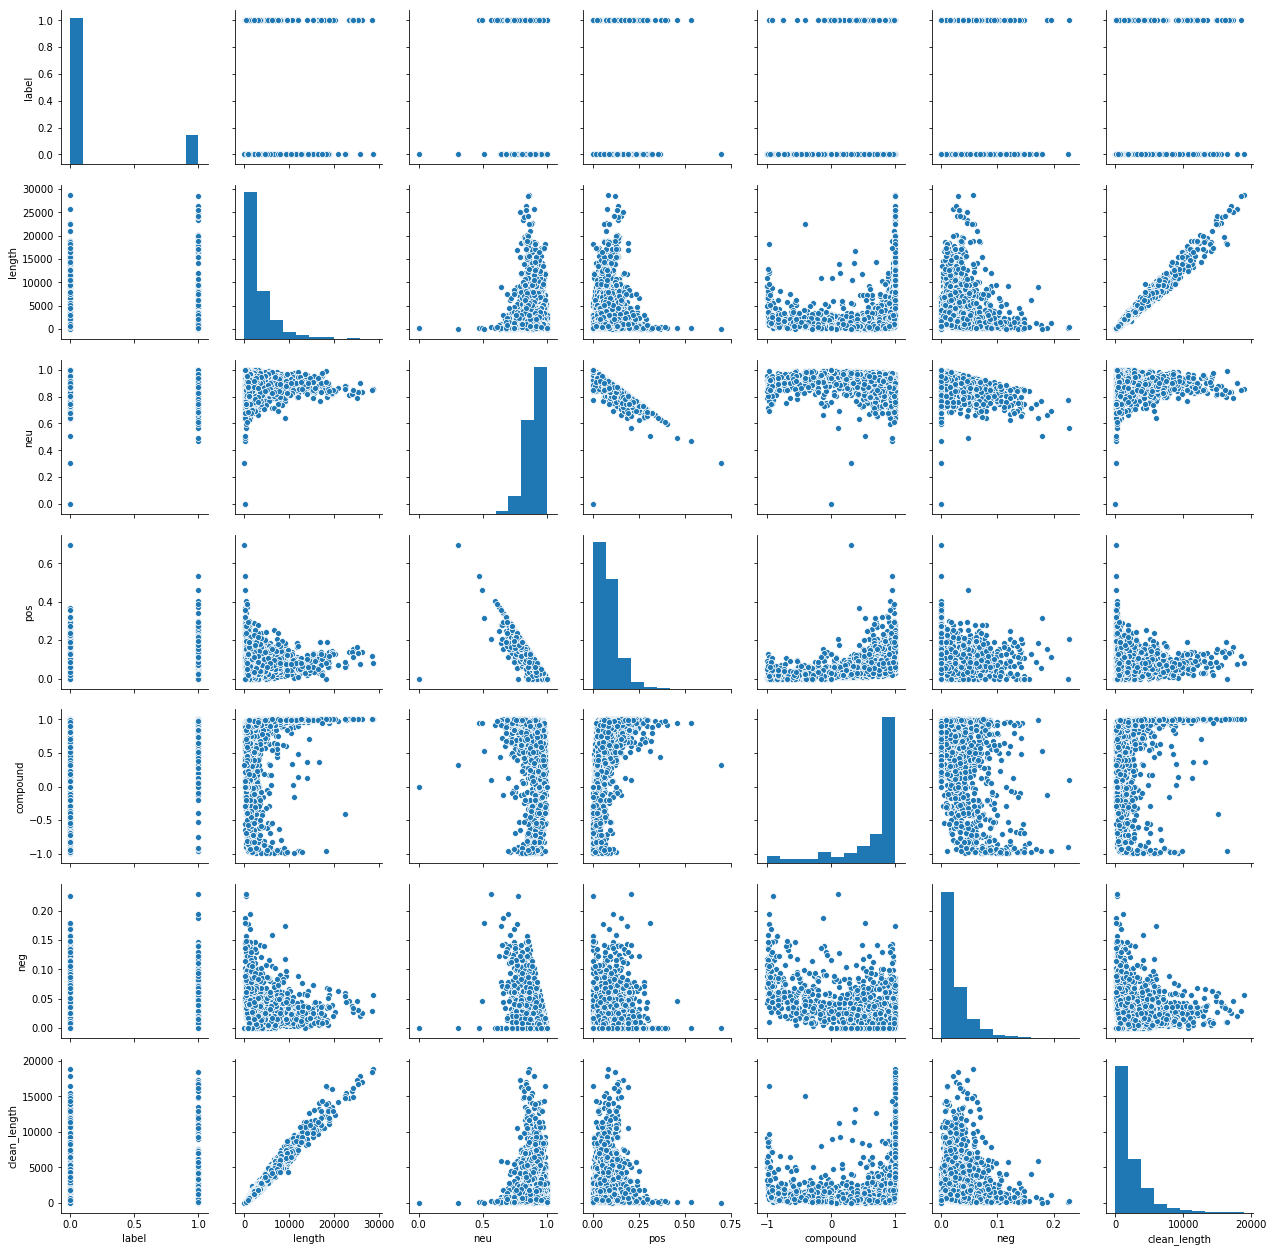

In [27]:
sns.pairplot(df)

AxesSubplot(0.125,0.125;0.775x0.755)


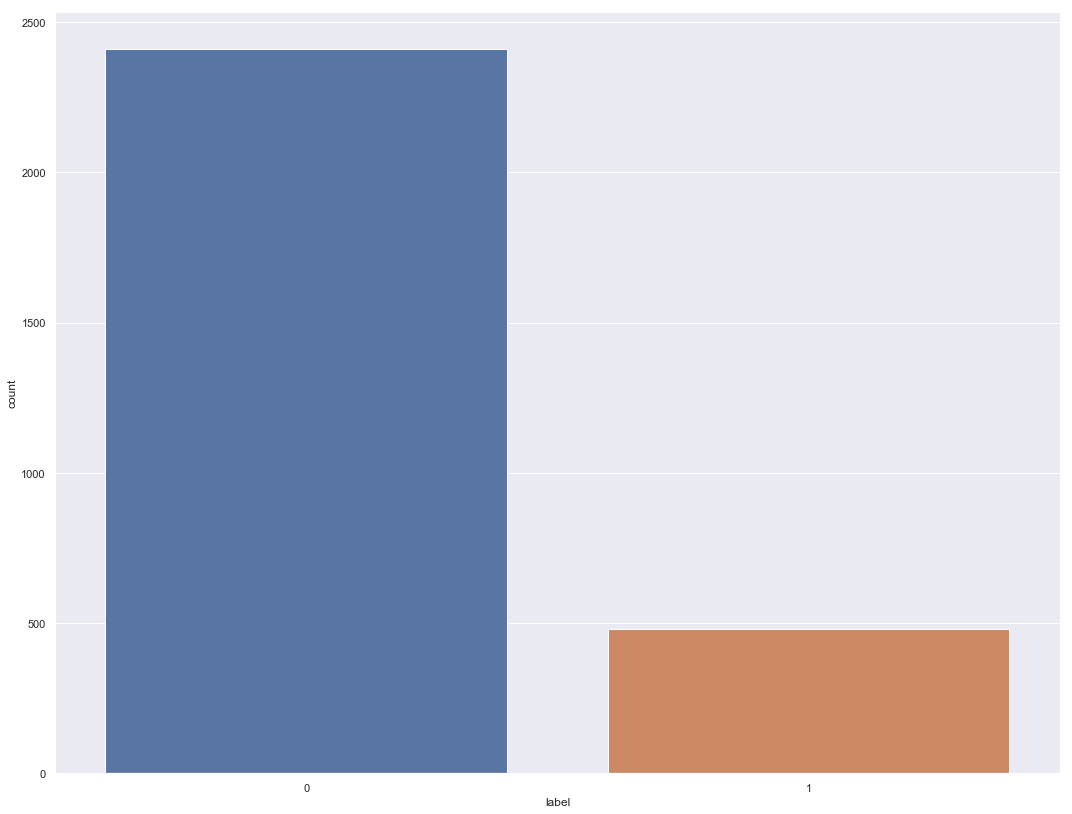

In [28]:
plt.figure(figsize=(18,14))
sns.set()
print(sns.countplot(df.label))

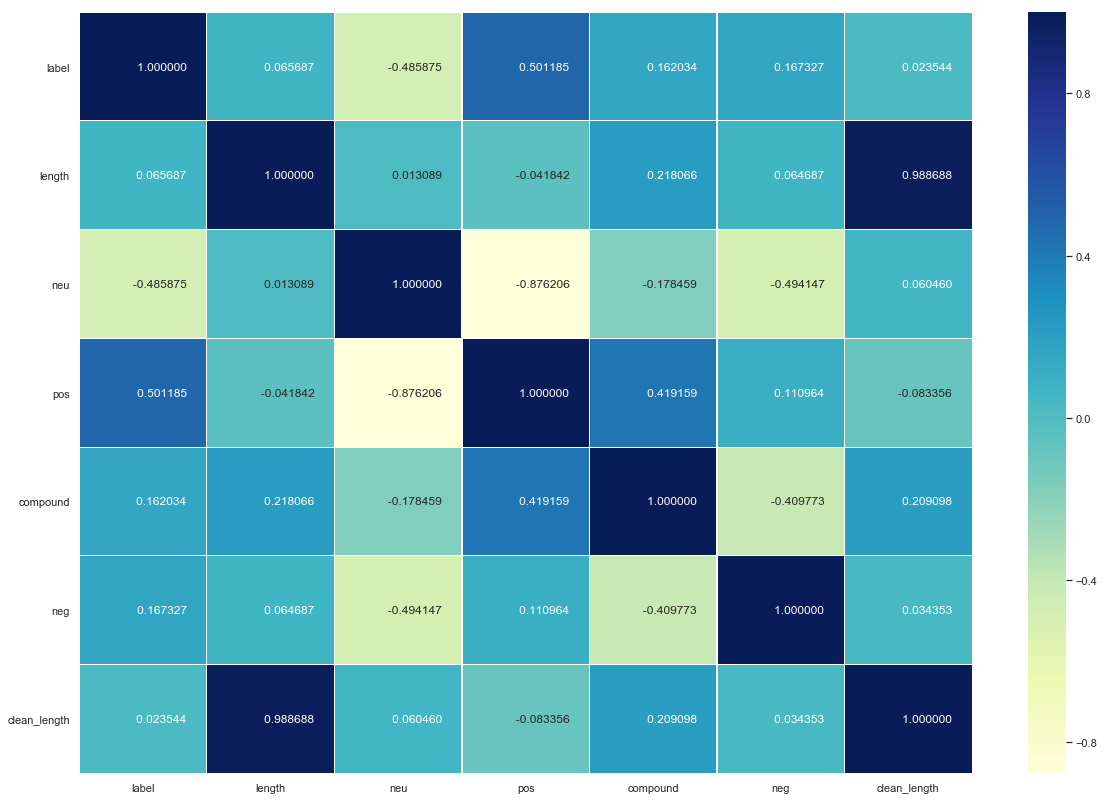

In [29]:
plt.figure(figsize=(20,14))
sns.heatmap(df.corr(),linewidths=.1,fmt="19f",cmap="YlGnBu", annot=True)
plt.yticks(rotation=0);

In [30]:
print ('Origian Length', df.length.sum())
print ('Clean Length', df.clean_length.sum())

Origian Length 9344743
Clean Length 6767857


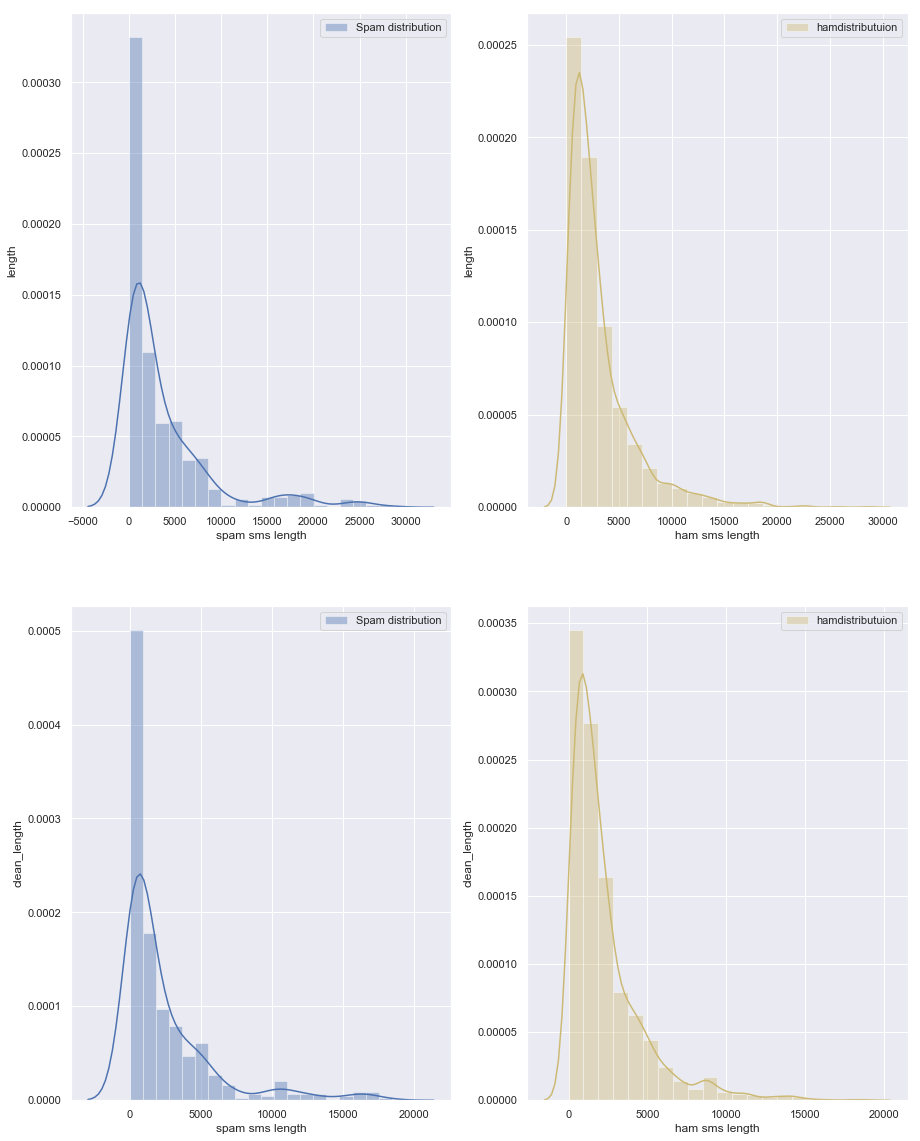

In [31]:
f,ax = plt.subplots(2,2 , figsize =(15,20))
sns.distplot(df[df['label']==1]['length'],bins=20,ax=ax[0,0],label='Spam distribution',color='b')

sns.distplot(df[df['label']==0]['length'],bins=20,ax=ax[0,1],label='hamdistributuion',color='y')
ax[0,0].set_xlabel('spam sms length')
ax[0,1].set_xlabel('ham sms length')
ax[0,0].set_ylabel('length')
ax[0,1].set_ylabel('length')
ax[0,0].legend()
ax[0,1].legend()


sns.distplot(df[df['label']==1]['clean_length'],bins=20,ax=ax[1,0],label='Spam distribution',color='b')

sns.distplot(df[df['label']==0]['clean_length'],bins=20,ax=ax[1,1],label='hamdistributuion',color='y')
ax[1,0].set_xlabel('spam sms length')
ax[1,1].set_xlabel('ham sms length')
ax[1,0].set_ylabel('clean_length')
ax[1,1].set_ylabel('clean_length')
ax[1,0].legend()
ax[1,1].legend()

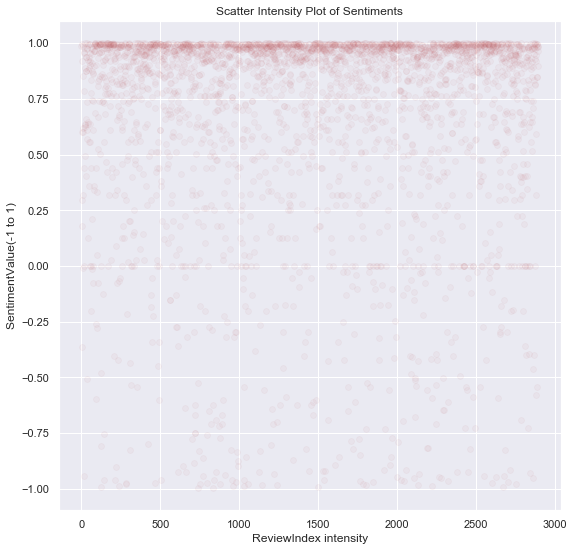

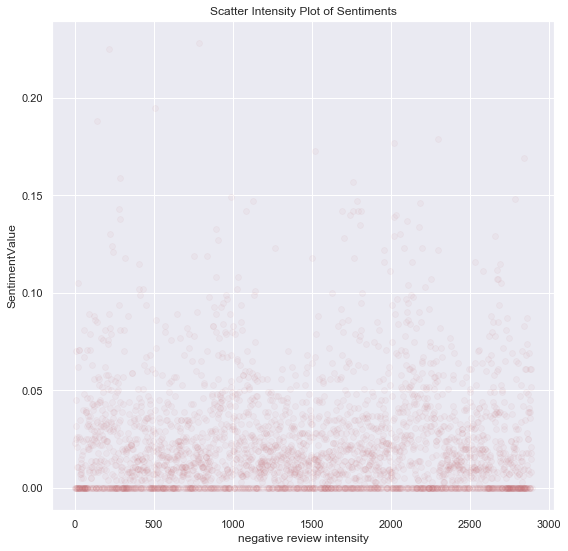

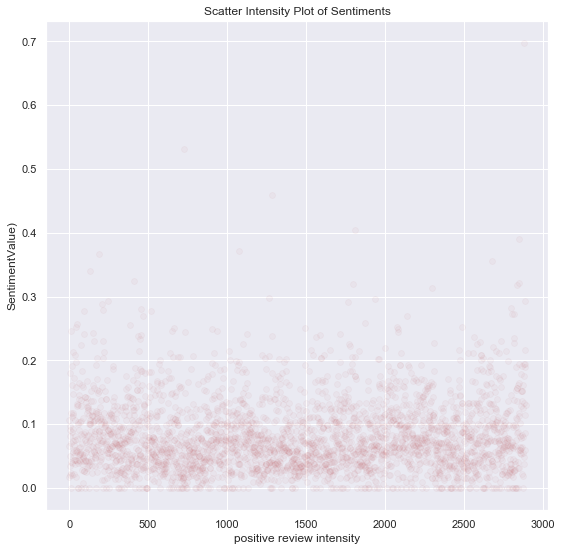

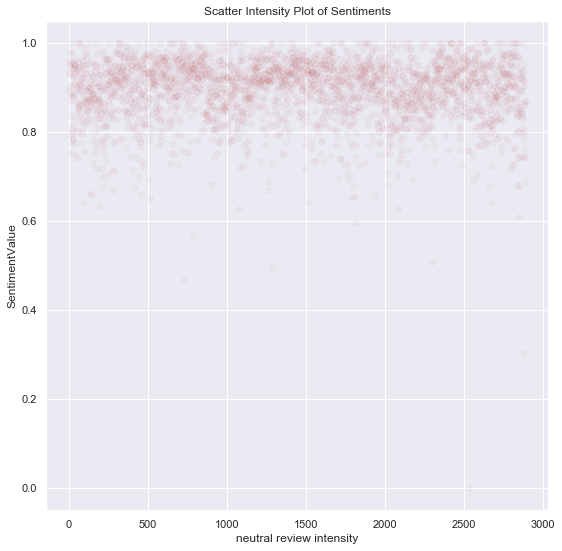

In [32]:
all_sent_values=[]
xaxis = []
for i in range(0,2893):
    xaxis.append(i)
    all_sent_values.append(df['compound'][i])
ylabel_new_1 = all_sent_values[:2893]

xlabel = xaxis
plt.figure(figsize=(9,9))
plt.xlabel('ReviewIndex intensity')
plt.ylabel('SentimentValue(-1 to 1)')
plt.plot(xlabel, ylabel_new_1, 'ro',  alpha=0.04)

plt.title('Scatter Intensity Plot of Sentiments')
plt.show()

all_sent_values=[]
xaxis = []
for i in range(0,2893):
    xaxis.append(i)
    all_sent_values.append(df['neg'][i])
ylabel_new_1 = all_sent_values[:2893]

xlabel = xaxis
plt.figure(figsize=(9,9))
plt.xlabel('negative review intensity')
plt.ylabel('SentimentValue')
plt.plot(xlabel, ylabel_new_1, 'ro',  alpha=0.04)

plt.title('Scatter Intensity Plot of Sentiments')
plt.show()
all_sent_values=[]
xaxis = []
for i in range(0,2893):
    xaxis.append(i)
    all_sent_values.append(df['pos'][i])
ylabel_new_1 = all_sent_values[:2893]

xlabel = xaxis
plt.figure(figsize=(9,9))
plt.xlabel('positive review intensity')
plt.ylabel('SentimentValue)')
plt.plot(xlabel, ylabel_new_1, 'ro',  alpha=0.04)

plt.title('Scatter Intensity Plot of Sentiments')
plt.show()
all_sent_values=[]
xaxis = []
for i in range(0,2893):
    xaxis.append(i)
    all_sent_values.append(df['neu'][i])
ylabel_new_1 = all_sent_values[:2893]

xlabel = xaxis
plt.figure(figsize=(9,9))
plt.xlabel('neutral review intensity')
plt.ylabel('SentimentValue')
plt.plot(xlabel, ylabel_new_1, 'ro',  alpha=0.04)

plt.title('Scatter Intensity Plot of Sentiments')
plt.show()

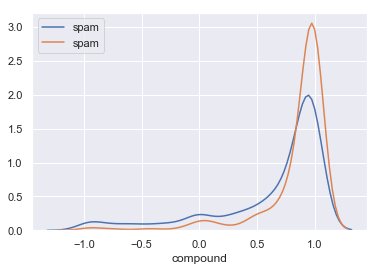

In [33]:
for x in [0,1]:
    subset = df[df['label'] == x]
    
    # Draw the density plot
    if x == '0':
        label = "valid mail"
    else:
        label = "spam"
    sns.distplot(subset['compound'], hist = False, label = label)

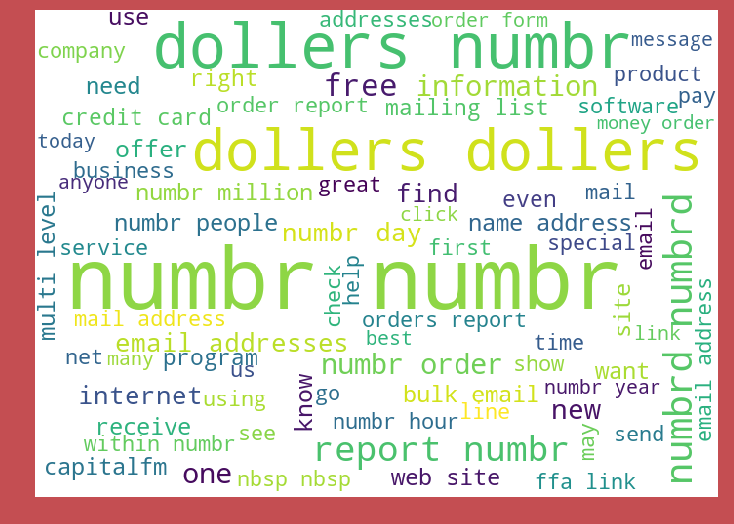

In [34]:
from wordcloud import WordCloud


spams = df['message1'][df['label']==1]

spam_cloud = WordCloud(width=700,height=500,background_color='white',max_words=75).generate(' '.join(spams))

plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(spam_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

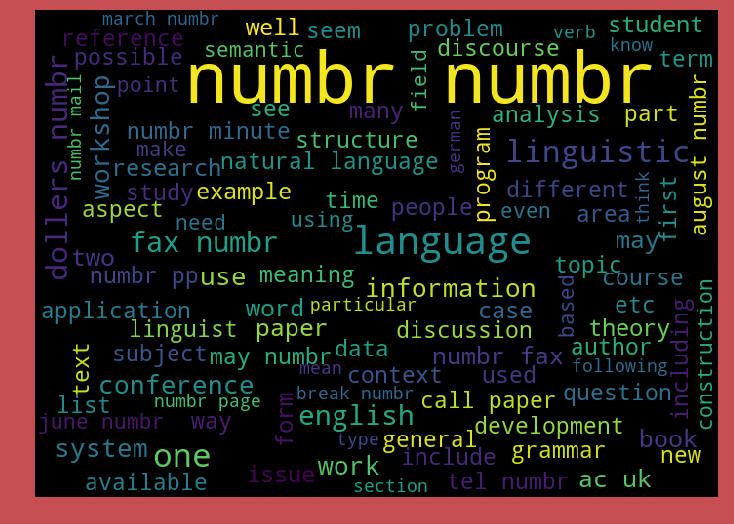

In [35]:
spams = df['message1'][df['label']==0]

spam_cloud = WordCloud(width=700,height=500,background_color='black',max_words=100).generate(' '.join(spams))

plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(spam_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

# Modelling reviewer_score

In [36]:
naive = MultinomialNB()
rf = RandomForestClassifier(n_estimators = 100, random_state = 42)
svm = SVC(random_state = 1)
dtc = DecisionTreeClassifier()
knn = KNeighborsClassifier(n_neighbors = 2)
model = LogisticRegression()
z=[naive,rf,svm,dtc,knn,model]

final score MultinomialNB() with TfidfVectorizer() = > 0.81353591160221
              precision    recall  f1-score   support

           0       0.81      1.00      0.90       585
           1       1.00      0.03      0.06       139

    accuracy                           0.81       724
   macro avg       0.91      0.51      0.48       724
weighted avg       0.85      0.81      0.74       724



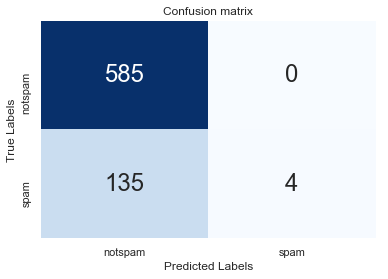

final score RandomForestClassifier(random_state=42) with TfidfVectorizer() = > 0.9709944751381215
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       585
           1       1.00      0.85      0.92       139

    accuracy                           0.97       724
   macro avg       0.98      0.92      0.95       724
weighted avg       0.97      0.97      0.97       724



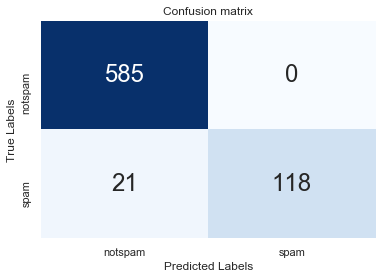

final score SVC(random_state=1) with TfidfVectorizer() = > 0.9834254143646409
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       585
           1       1.00      0.91      0.95       139

    accuracy                           0.98       724
   macro avg       0.99      0.96      0.97       724
weighted avg       0.98      0.98      0.98       724



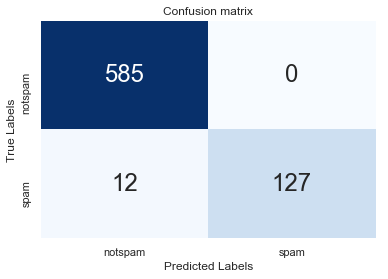

final score DecisionTreeClassifier() with TfidfVectorizer() = > 0.9668508287292817
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       585
           1       0.95      0.87      0.91       139

    accuracy                           0.97       724
   macro avg       0.96      0.93      0.94       724
weighted avg       0.97      0.97      0.97       724



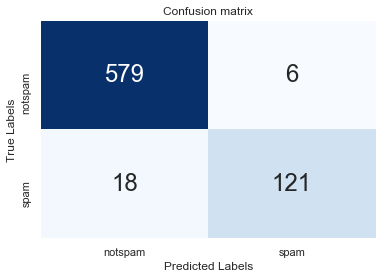

final score KNeighborsClassifier(n_neighbors=2) with TfidfVectorizer() = > 0.8701657458563536
              precision    recall  f1-score   support

           0       0.86      1.00      0.93       585
           1       1.00      0.32      0.49       139

    accuracy                           0.87       724
   macro avg       0.93      0.66      0.71       724
weighted avg       0.89      0.87      0.84       724



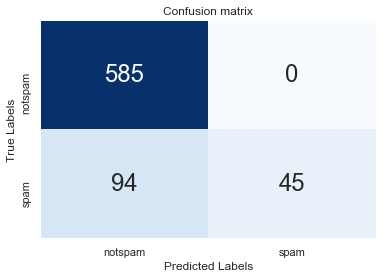

final score LogisticRegression() with TfidfVectorizer() = > 0.9737569060773481
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       585
           1       1.00      0.86      0.93       139

    accuracy                           0.97       724
   macro avg       0.98      0.93      0.96       724
weighted avg       0.97      0.97      0.97       724



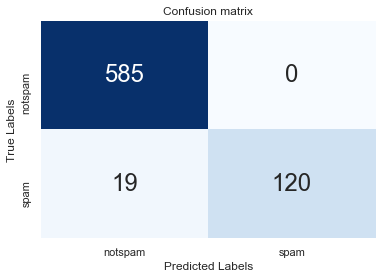

final score MultinomialNB() with CountVectorizer() = > 0.9903314917127072
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       585
           1       0.96      0.99      0.98       139

    accuracy                           0.99       724
   macro avg       0.98      0.99      0.98       724
weighted avg       0.99      0.99      0.99       724



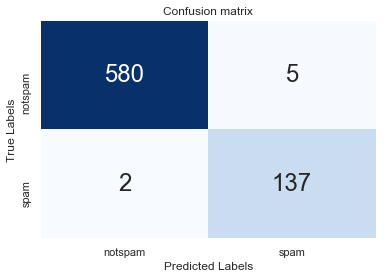

final score RandomForestClassifier(random_state=42) with CountVectorizer() = > 0.9737569060773481
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       585
           1       1.00      0.86      0.93       139

    accuracy                           0.97       724
   macro avg       0.98      0.93      0.96       724
weighted avg       0.97      0.97      0.97       724



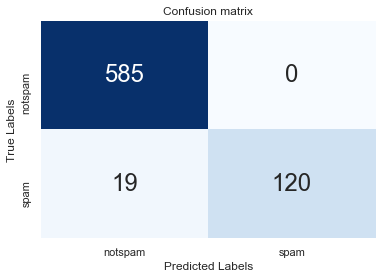

final score SVC(random_state=1) with CountVectorizer() = > 0.9323204419889503
              precision    recall  f1-score   support

           0       0.92      1.00      0.96       585
           1       1.00      0.65      0.79       139

    accuracy                           0.93       724
   macro avg       0.96      0.82      0.87       724
weighted avg       0.94      0.93      0.93       724



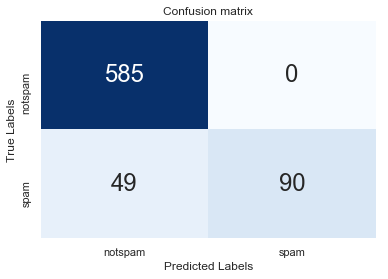

final score DecisionTreeClassifier() with CountVectorizer() = > 0.9751381215469613
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       585
           1       0.95      0.92      0.93       139

    accuracy                           0.98       724
   macro avg       0.96      0.95      0.96       724
weighted avg       0.97      0.98      0.97       724



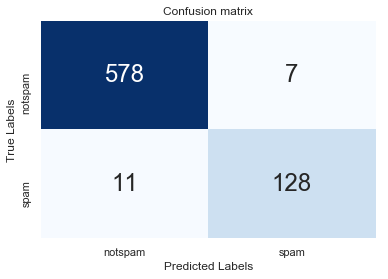

final score KNeighborsClassifier(n_neighbors=2) with CountVectorizer() = > 0.9461325966850829
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       585
           1       0.98      0.73      0.84       139

    accuracy                           0.95       724
   macro avg       0.96      0.87      0.90       724
weighted avg       0.95      0.95      0.94       724



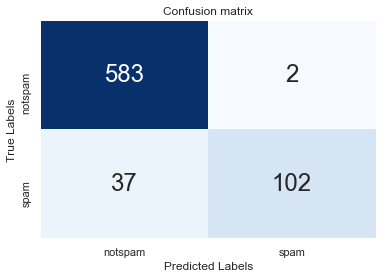

final score LogisticRegression() with CountVectorizer() = > 0.9930939226519337
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       585
           1       0.99      0.97      0.98       139

    accuracy                           0.99       724
   macro avg       0.99      0.98      0.99       724
weighted avg       0.99      0.99      0.99       724



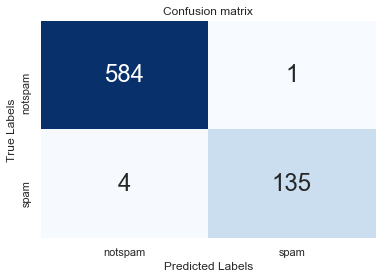

In [37]:
z=[naive,rf,svm,dtc,knn,model]
tf_vec = TfidfVectorizer()
vect1 = CountVectorizer(ngram_range=(1,1))
model1=[]
accuracy_score1 =[]
s=[tf_vec,vect1]
for k in s:
    X = df.loc[:,('message')]

    features = k.fit_transform(X)

    X = features
    y = df['label']
    X_train,x_test,Y_train,y_test = train_test_split(X,y,random_state=42)
    for i in z:
        i.fit(X_train,Y_train)
        y_pred = i.predict(x_test)
        print('final score {} with {} = >' .format(i,k),accuracy_score(y_test,y_pred))
        x=(' {}  {}' .format(i,k))
        model1.append(x)
        print(classification_report(y_test, y_pred))
        accuracy_score1.append(accuracy_score(y_test,y_pred))
        
        conf_mat = confusion_matrix(y_test,y_pred)
        conf_mat = confusion_matrix(y_test,y_pred)

        ax=plt.subplot()
        
        sns.heatmap(conf_mat,ax=ax,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})
        #sns.heatmap(conf_mat,annot=True,ax=ax,linewidths=5,linecolor='r',center=0)
        ax.set_xlabel('Predicted Labels');ax.set_ylabel('True Labels')

        ax.set_title('Confusion matrix')
        ax.xaxis.set_ticklabels(['notspam','spam'])
        ax.yaxis.set_ticklabels(['notspam','spam'])
        plt.show()


# Model Selection/Conclusion

In [38]:
df1 = pd.DataFrame(list(zip(model1, accuracy_score1)), 
               columns =['model1', 'accuracy_score1']) 
df1 

model1  accuracy_score1
0                  MultinomialNB()  TfidfVectorizer()         0.813536
1    RandomForestClassifier(random_state=42)  Tfid...         0.970994
2              SVC(random_state=1)  TfidfVectorizer()         0.983425
3         DecisionTreeClassifier()  TfidfVectorizer()         0.966851
4    KNeighborsClassifier(n_neighbors=2)  TfidfVec...         0.870166
5             LogisticRegression()  TfidfVectorizer()         0.973757
6                  MultinomialNB()  CountVectorizer()         0.990331
7    RandomForestClassifier(random_state=42)  Coun...         0.973757
8              SVC(random_state=1)  CountVectorizer()         0.932320
9         DecisionTreeClassifier()  CountVectorizer()         0.975138
10   KNeighborsClassifier(n_neighbors=2)  CountVec...         0.946133
11            LogisticRegression()  CountVectorizer()         0.993094

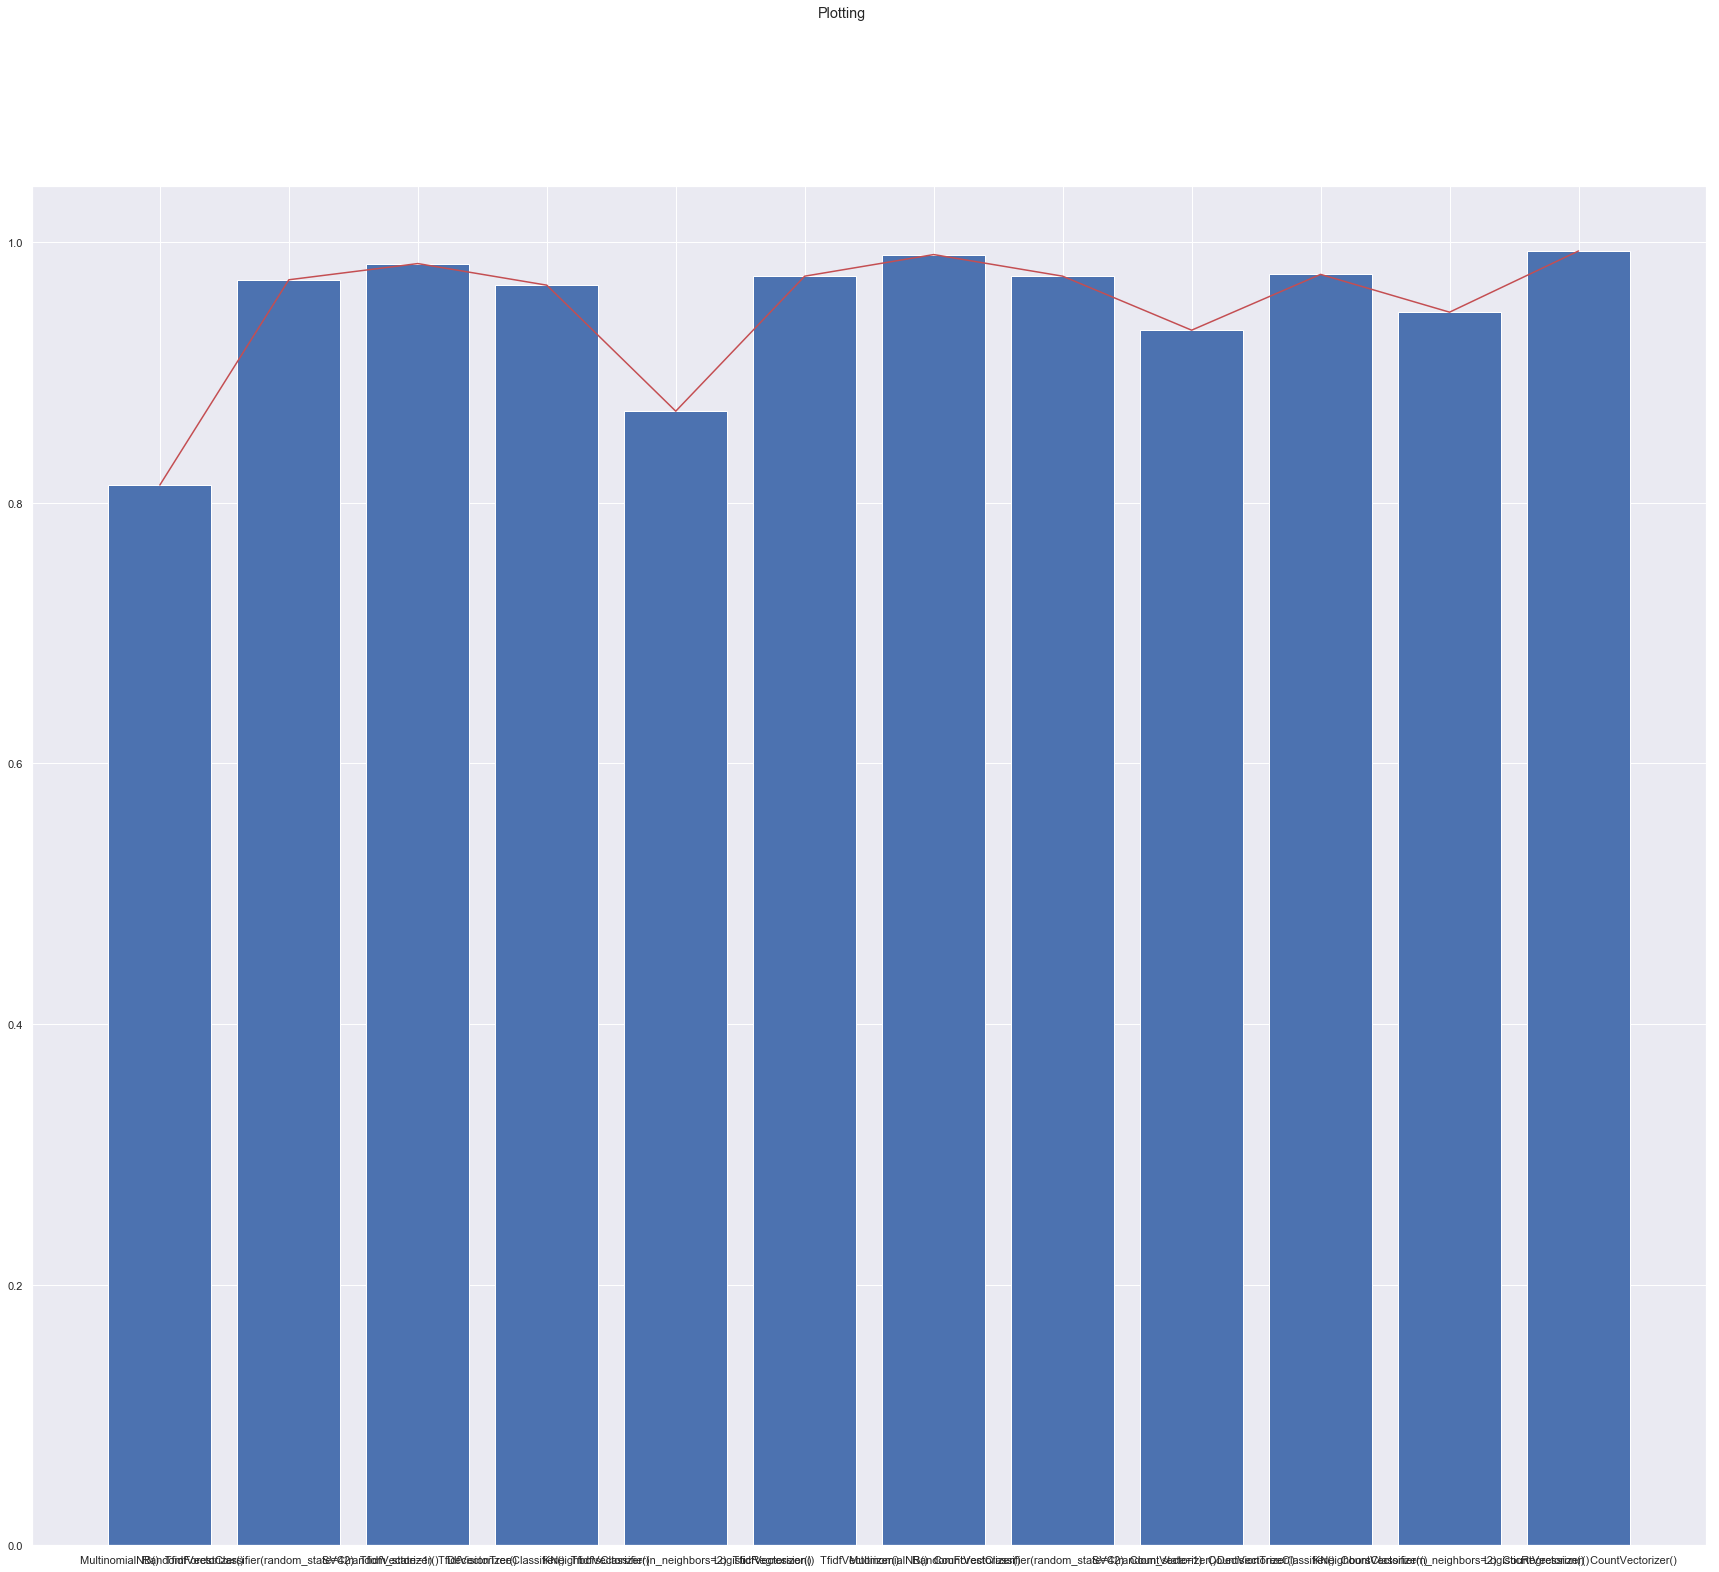

In [39]:
plt.figure(figsize=(30,25))
plt.plot(model1, accuracy_score1,c='r')
plt.bar(model1, accuracy_score1)
plt.suptitle('Plotting')

plt.show()

# The best regression model for this is LogisticRegression() CountVectorizer()	with accuracy score is 0.993094

final score LogisticRegression() with CountVectorizer() = > 0.9930939226519337
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       585
           1       0.99      0.97      0.98       139

    accuracy                           0.99       724
   macro avg       0.99      0.98      0.99       724
weighted avg       0.99      0.99      0.99       724



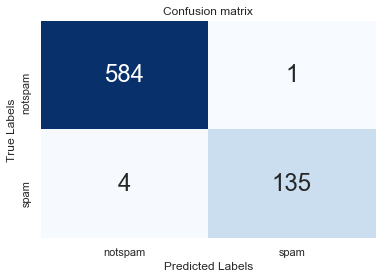

threshold the probabilities to give class predictions : 1.0
Auc_roc value : 0.984756809936666
roc_auc value: 0.9945151571050852


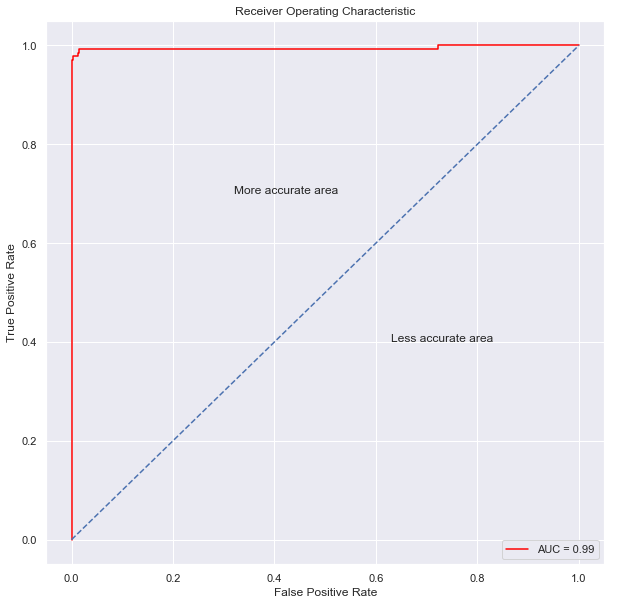

In [73]:
z=[model]
tf_vec = TfidfVectorizer()
vect1 = CountVectorizer(ngram_range=(1,1))
model1=[]
accuracy_score1 =[]
s=[vect1]
for k in s:
    X = df.loc[:,('message')]

    features = k.fit_transform(X)

    X = features
    y = df['label']
    X_train,x_test,Y_train,y_test = train_test_split(X,y, random_state=42)
    for i in z:
        i.fit(X_train,Y_train)
        y_pred = i.predict(x_test)
        print('final score {} with {} = >' .format(i,k),accuracy_score(y_test,y_pred))
        x=(' {}  {}' .format(i,k))
        model1.append(x)
        print(classification_report(y_test, y_pred))
        accuracy_score1.append(accuracy_score(y_test,y_pred))
        
        conf_mat = confusion_matrix(y_test,y_pred)
        conf_mat = confusion_matrix(y_test,y_pred)

        ax=plt.subplot()
        
        sns.heatmap(conf_mat,ax=ax,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})
        #sns.heatmap(conf_mat,annot=True,ax=ax,linewidths=5,linecolor='r',center=0)
        ax.set_xlabel('Predicted Labels');ax.set_ylabel('True Labels')

        ax.set_title('Confusion matrix')
        ax.xaxis.set_ticklabels(['notspam','spam'])
        ax.yaxis.set_ticklabels(['notspam','spam'])
        plt.show()
        y_pred = np.where(y_prob > 0.5, 1, 0) # This will threshold the probabilities to give class predictions.
        print( "threshold the probabilities to give class predictions : {}" .format(model.score(x_test, y_pred)))
        auc_roc=metrics.roc_auc_score(y_test,y_pred)
        print( "Auc_roc value : {}" .format(auc_roc))
        
        
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        print("roc_auc value: {}" .format(roc_auc))
        
        
        plt.figure(figsize=(10,10))
        plt.title('Receiver Operating Characteristic')
        plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],linestyle='--')
        plt.axis('tight')
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.text(0.32,0.7,'More accurate area',fontsize = 12)
        plt.text(0.63,0.4,'Less accurate area',fontsize = 12)